In [ ]:
!pip install scikit-posthocs

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from google.colab import drive
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from tqdm import tqdm
import inspect
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [ ]:
def preprocess_data(file_path):
    """Preprocesses and balances the dataset."""
    oscc = pd.read_csv(file_path)

    # Rename last column to 'Target' if it's not already named that
    if oscc.columns[-1] != 'Target':
        oscc = oscc.rename(columns={oscc.columns[-1]: 'Target'})

    X = oscc.drop('Target', axis=1)
    y = oscc['Target']
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    oscc = pd.DataFrame(X, columns=oscc.columns[:-1])
    oscc['Target'] = y
    return oscc

# Specify the directory path
directory_path = "/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm"

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

# Dictionary to store the preprocessed DataFrames
preprocessed_dataframes = {}

# Process each CSV file
for filename in csv_files:
    file_path = os.path.join(directory_path, filename)
    print(f"Processing file: {filename}")

    # Preprocess and balance the data
    data = preprocess_data(file_path)

    # Store the preprocessed DataFrame in the dictionary
    dataframe_name = filename.replace(".csv", "_data")  # Create a name for the DataFrame
    preprocessed_dataframes[dataframe_name] = data

    print(f"Preprocessed data stored in DataFrame: {dataframe_name}")

oscc = preprocessed_dataframes['OSCC_data']
leukemia = preprocessed_dataframes['Leukemia_data']
cns = preprocessed_dataframes['CNS_data']
colon = preprocessed_dataframes['Colon_data']
breast = preprocessed_dataframes['Breast_data']
ovarian = preprocessed_dataframes['Ovarian_data']

Processing file: Colon.csv
Preprocessed data stored in DataFrame: Colon_data
Processing file: CNS.csv
Preprocessed data stored in DataFrame: CNS_data
Processing file: Leukemia.csv
Preprocessed data stored in DataFrame: Leukemia_data
Processing file: Breast.csv
Preprocessed data stored in DataFrame: Breast_data
Processing file: OSCC.csv
Preprocessed data stored in DataFrame: OSCC_data
Processing file: Ovarian.csv
Preprocessed data stored in DataFrame: Ovarian_data


In [ ]:
# def get_dataset_info(file_path):
#     """Gets dataset information before SMOTE."""
#     df = pd.read_csv(file_path)

#     # Rename last column to 'Target' if necessary
#     if df.columns[-1] != 'Target':
#         df = df.rename(columns={df.columns[-1]: 'Target'})

#     rows, cols = df.shape
#     target_counts = df['Target'].value_counts().to_dict()

#     return rows, cols, target_counts

# # Specify the directory path
# directory_path = "/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm"

# # Get a list of all CSV files in the directory
# csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

# # Create an empty list to store the data for the table
# table_data = []

# # Iterate through each CSV file and extract information
# for filename in csv_files:
#     file_path = os.path.join(directory_path, filename)

#     # Get dataset information
#     rows, cols, target_counts = get_dataset_info(file_path)

#     # Append the data to the list
#     table_data.append([filename.replace(".csv", ""), rows, cols, target_counts])

# # Create a Pandas DataFrame from the table data
# dataset_info_df = pd.DataFrame(table_data, columns=['Dataset', 'Rows', 'Columns', 'Target Value Counts'])

# # Display the DataFrame
# dataset_info_df

,Dataset,Rows,Columns,Target Value Counts
0,Colon,62,2001,"{0: 40, 1: 22}"
1,CNS,60,7130,"{0: 39, 1: 21}"
2,Leukemia,72,7130,"{0: 47, 1: 25}"
3,Breast,97,24482,"{1: 51, 0: 46}"
4,OSCC,50,41004,"{1: 35, 0: 15}"
5,Ovarian,253,15155,"{1: 162, 0: 91}"


In [ ]:
# Assuming you have the preprocessed_dataframes dictionary
dataframes = {
    'oscc': oscc,
    'leukemia': leukemia,
    'cns': cns,
    'colon': colon,
    'breast': breast,
    'ovarian': ovarian
}

# Create an empty list to store the data for the table
table_data = []

# Iterate through each dataset and extract information
for name, df in dataframes.items():
    shape = df.shape
    target_counts = df['Target'].value_counts().to_dict()  # Convert to dictionary

    # Append the data to the list
    table_data.append([name, shape[0], shape[1], target_counts])

# Create a Pandas DataFrame from the table data
table_df = pd.DataFrame(table_data, columns=['Dataset', 'Rows', 'Columns', 'Target Value Counts'])

# Save the DataFrame to a CSV file
table_df.to_csv('dataset_summary.csv', index=False)

# Infected Hyna Optimization

In [ ]:
def IHO(X, y, pop_size=50, max_iter=50, infection_rate=0.2, mutation_rate=0.3, a_max=2, alpha=0.1):

    _, dim = X.shape
    intercept = 0
    best_intercept = {intercept: 0}  # Initialize with intercept and initial fitness
    name = 'IHO'
    fitness_history = []

    def calculate_accuracy(individual, X, y, intercept, alpha):
        y_pred = intercept + np.dot(X, individual)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = accuracy_score(y, y_pred)
        penalty = alpha * np.sum(np.abs(individual))
        return accuracy - penalty

    def encircle_prey(hyena, prey, a):
        r1 = np.random.uniform(0, 1, dim)
        r2 = np.random.uniform(0, 1, dim)
        A = 2 * a * r1 - a
        C = 2 * r2
        D_prey = np.abs(C * prey - hyena)
        return prey - A * D_prey

    def gaussian_diffusion(individual, gbest, step_size = 0.01):
        r1, r2 = np.random.uniform(0, 1, 2)
        gaussian_perturbation = np.random.normal(gbest, step_size, dim)
        new_position = gbest + (r1 * gbest - r2 * individual) + gaussian_perturbation
        return new_position

    def virus_infection(individual):
        infection = np.random.uniform(-infection_rate, infection_rate, dim)
        return individual + infection

    def mutation(individual):
        mutation = np.random.uniform(-mutation_rate, mutation_rate, dim)
        return individual + mutation

    def attack_prey(hyenas, prey, B, E):
        D_h = np.abs(B * prey - hyenas)
        P_k = prey - E * D_h
        C_h = np.mean(P_k, axis=0)
        new_prey = C_h / len(hyenas)
        return new_prey

    population = np.random.rand(pop_size, dim)
    fitness = np.array([calculate_accuracy(ind, X, y, intercept, alpha) for ind in population])
    best_index = np.argmax(fitness)
    best = population[best_index]
    best_fitness = fitness[best_index]

    for iteration in tqdm(range(max_iter), desc="IHO Optimization"):
        a = a_max - (iteration * (a_max / max_iter * 2))

        for i in range(pop_size):
            if np.random.rand() < 0.4:
                new_position = encircle_prey(population[i], best, a)
                if np.random.rand() < 0.7:
                    new_position = gaussian_diffusion(population[i], best, step_size = 0.1)
            else:
                new_position = virus_infection(population[i])
                if np.random.rand() < 0.2:
                    new_position = mutation(new_position)

            if np.random.rand() < 0.3:
                new_position = attack_prey(population, best, B = 1.5, E = np.random.uniform(-1, 1))

            intercept = np.mean(y - np.dot(X, new_position))
            new_fitness = calculate_accuracy(new_position, X, y, intercept, alpha)

            if new_fitness > fitness[i]:
                population[i] = new_position
                fitness[i] = new_fitness
                if new_fitness > max(best_intercept.values()):
                    best_intercept.clear()
                    best_intercept[intercept] = new_fitness

        # Update the best solution
        best_index = np.argmax(fitness)
        best = population[best_index]
        best_fitness = fitness[best_index]
        fitness_history.append(best_fitness)

    return best, best_fitness, fitness_history, best_intercept, name


# Differential Evolution

In [ ]:
def DE(X, y, pop_size=30, max_iters=1000, scaling_factor=0.5, crossover_probability=0.5, alpha=0.1):

    _, dim = X.shape
    intercept = 0
    best_intercept = {intercept: 0}  # Initialize with intercept and initial fitness
    name = 'DE'
    fitness_history = []

    def calculate_accuracy(individual, X, y, intercept, alpha):
        y_pred = intercept + np.dot(X, individual)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = accuracy_score(y, y_pred)
        penalty = alpha * np.sum(np.abs(individual))
        return accuracy - penalty

    population = np.random.rand(pop_size, dim)
    fitness = np.array([calculate_accuracy(ind, X, y, intercept, alpha) for ind in population])
    best_index = np.argmax(fitness)
    best = population[best_index]
    best_fitness = fitness[best_index]

    for t in tqdm(range(max_iters), desc="DE Optimization"):
        for i in range(pop_size):
            # Select three random indices
            indices = list(range(pop_size))
            indices.remove(i)  # Ensure we don't select the current individual
            a, b, c = np.random.choice(indices, 3, replace=False)

            # Create a mutant vector
            mutant = population[a] + scaling_factor * (population[b] - population[c])

            # Create a trial vector
            trial = np.copy(population[i])
            for j in range(dim):
                if np.random.rand() < crossover_probability:
                    trial[j] = mutant[j]

            # Evaluate fitness of trial vector
            intercept = np.mean(y - np.dot(X, trial))
            trial_fitness = calculate_accuracy(trial, X, y, intercept, alpha)

            if trial_fitness > fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness
                if trial_fitness > max(best_intercept.values()):
                    best_intercept.clear()
                    best_intercept[intercept] = trial_fitness

        # Randomly reinitialize part of the population to prevent local minima
        if np.random.rand() < 0.1:  # 10% chance to reinitialize
            num_to_reinitialize = pop_size // 10  # Reinitialize 10% of the population
            indices_to_reinitialize = np.random.choice(pop_size, num_to_reinitialize, replace=False)
            population[indices_to_reinitialize] = np.random.rand(num_to_reinitialize, dim)

        # Update the best solution
        best_index = np.argmax(fitness)
        best = population[best_index]
        best_fitness = fitness[best_index]
        fitness_history.append(best_fitness)

    return best, best_fitness, fitness_history, best_intercept, name

# Grey Wolf Optimizer

In [ ]:
def GWO(X, y, pop_size=30, max_iters=1000, alpha=0.1):

    _, dim = X.shape
    intercept = 0
    best_intercept = {intercept: 0}  # Initialize with intercept and initial fitness
    name = 'GWO'
    fitness_history = []

    def calculate_accuracy(individual, X, y, intercept, alpha):
        y_pred = intercept + np.dot(X, individual)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = accuracy_score(y, y_pred)
        penalty = alpha * np.sum(np.abs(individual))
        return accuracy - penalty

    population = np.random.rand(pop_size, dim)
    fitness_list = np.array([calculate_accuracy(ind, X, y, intercept, alpha) for ind in population])
    best_index = np.argmax(fitness_list)
    best = population[best_index]
    best_fitness = fitness_list[best_index]

    # Initialize alpha, beta, and delta wolves
    alpha_wolf, beta_wolf, delta_wolf = np.zeros(dim), np.zeros(dim), np.zeros(dim)
    alpha_fitness, beta_fitness, delta_fitness = float("inf"), float("inf"), float("inf")

    for t in tqdm(range(max_iters), desc="GWO Optimization"):
        # Decrease parameter 'a' from 2 to 0 linearly
        a = 2 - t * (2 / max_iters)

        for i in range(pop_size):
            intercept = np.mean(y - np.dot(X, population[i]))
            fitness = calculate_accuracy(population[i], X, y, intercept, alpha)
            if fitness > alpha_fitness:
                alpha_fitness, alpha_wolf = fitness, population[i].copy()
            elif fitness > beta_fitness:
                beta_fitness, beta_wolf = fitness, population[i].copy()
            elif fitness > delta_fitness:
                delta_fitness, delta_wolf = fitness, population[i].copy()

        # Update position of each wolf
        for i in range(pop_size):
            # Position update equations
            r1, r2 = np.random.rand(), np.random.rand()
            A1 = 2 * a * r1 - a
            C1 = 2 * r2
            D_alpha = np.abs(C1 * alpha_wolf - population[i])
            X1 = alpha_wolf - A1 * D_alpha

            r1, r2 = np.random.rand(), np.random.rand()
            A2 = 2 * a * r1 - a
            C2 = 2 * r2
            D_beta = np.abs(C2 * beta_wolf - population[i])
            X2 = beta_wolf - A2 * D_beta

            r1, r2 = np.random.rand(), np.random.rand()
            A3 = 2 * a * r1 - a
            C3 = 2 * r2
            D_delta = np.abs(C3 * delta_wolf - population[i])
            X3 = delta_wolf - A3 * D_delta

            # Update wolf position
            population[i] = (X1 + X2 + X3) / 3

            intercept = np.mean(y - np.dot(X, population[i]))
            new_fitness = calculate_accuracy(population[i], X, y, intercept, alpha)

            if new_fitness > fitness_list[i]:
                population[i] = population[i]
                fitness_list[i] = new_fitness
                if new_fitness > max(best_intercept.values()):
                    best_intercept.clear()
                    best_intercept[intercept] = new_fitness

        # Update the best solution
        best_index = np.argmax(fitness_list)
        best = population[best_index]
        best_fitness = fitness_list[best_index]
        fitness_history.append(best_fitness)

    return best, best_fitness, fitness_history, best_intercept, name

# Hunger Search Algorithm

In [ ]:
# Hyperbolic secant (sech)
def sech(x):
    if np.abs(x) > 20:  # Threshold to avoid overflow
        return 0  # Since sech(x) approaches 0 as x approaches ±∞
    return 2 / (np.exp(x) + np.exp(-x))

def HSA(X, y, pop_size=30, max_iters=1000, l=0.08, LH=100, alpha=0.1):

    fitness_history = []
    _, dim = X.shape
    intercept = 0
    best_intercept = {intercept: 0}  # Initialize with intercept and initial fitness
    name = 'HSA'

    def calculate_accuracy(individual, X, y, intercept, alpha):
        y_pred = intercept + np.dot(X, individual)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = accuracy_score(y, y_pred)
        penalty = alpha * np.sum(np.abs(individual))
        return accuracy - penalty

    population = np.random.rand(pop_size, dim)
    fit = np.array([calculate_accuracy(ind, X, y, intercept, alpha) for ind in population])
    best_index = np.argmax(fit)
    best_sol = population[best_index]
    best_fit = fit[best_index]

    # Initialize hunger, weights, and best solution
    eps = 1e-6  # Small epsilon to handle boundary issues
    hunger = np.ones(pop_size)
    W1 = np.ones(pop_size)
    W2 = np.ones(pop_size)
    shrink_rate = 2.0
    best_solution = None
    best_fitness = float("inf")

    for t in tqdm(range(max_iters), desc="HSA Optimization"):
        # Calculate fitness for each agent, penalize infeasible solutions
        fitness = np.array([calculate_accuracy(ind, X, y, intercept, alpha) for ind in population])

        # Continue even if some solutions are infeasible, penalize them
        worst_fitness = np.min(fitness)
        current_best_idx = np.argmax(fitness)
        current_best_fitness = fitness[current_best_idx]

        # Update the best solution if the current iteration finds a better one
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_solution = population[current_best_idx]

        # Update hunger and W1, W2 values
        sum_hunger = np.sum(hunger)

        for i in range(len(fitness)):  # Ensure we loop over the actual number of feasible individuals
            r3, r4, r5, r6, r = np.random.rand(5)

            if fitness[i] != best_fitness:
                TH = ((fitness[i] - best_fitness) / (worst_fitness - best_fitness + eps)) * r6 * 2
                H = LH * (1 + r) if TH < LH else TH
                hunger[i] += H
            else:
                hunger[i] = 0  # Best individual has zero hunger

            if r3 < l:
                W1[i] = hunger[i] * len(fitness) / sum_hunger * r4
            else:
                W1[i] = 1

            W2[i] = (1 - np.exp(-np.abs(hunger[i] - sum_hunger))) * r5 * 2

        # Update population based on the games
        for i in range(len(fitness)):  # Again, only loop over feasible individuals
            r1, r2 = np.random.rand(2)
            R = 2 * shrink_rate * np.random.rand() - shrink_rate

            # Generate a new candidate solution
            if r1 < l:
                new_solution = population[i] * (1 + np.random.normal(size=dim))
            elif r1 > l and r2 > sech(np.abs(fitness[i] - best_fitness)):
                new_solution = W1[i] * best_solution + R * W2[i] * np.abs(best_solution - population[i])
            elif r1 > l and r2 < sech(np.abs(fitness[i] - best_fitness)):
                new_solution = W1[i] * best_solution - R * W2[i] * np.abs(best_solution - population[i])


            # Evaluate fitness of trial vector
            intercept = np.mean(y - np.dot(X, new_solution))
            new_fitness = calculate_accuracy(new_solution, X, y, intercept, alpha)
            if new_fitness > fit[i]:
                population[i] = new_solution
                fit[i] = new_fitness
                if new_fitness > max(best_intercept.values()):
                    best_intercept.clear()
                    best_intercept[intercept] = new_fitness

        best_index = np.argmax(fit)
        best_sol = population[best_index]
        best_fit = fit[best_index]
        fitness_history.append(best_fit)

        # Reduce shrink rate
        shrink_rate = 2 * (1 - t / max_iters)

    return best_sol, best_fit, fitness_history, best_intercept, name

# Particle Swarm Optimization

In [ ]:
def PSO(X, y, pop_size=30, max_iters=1000, c1=2, c2=2, v_max=6, w=1, alpha=0.1):

    fitness_history = []
    _, dim = X.shape
    intercept = 0
    best_intercept = {intercept: 0}  # Initialize with intercept and initial fitness
    name = 'PSO'

    def calculate_accuracy(individual, X, y, intercept, alpha):
        y_pred = intercept + np.dot(X, individual)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = accuracy_score(y, y_pred)
        penalty = alpha * np.sum(np.abs(individual))
        return accuracy - penalty

    # Initialize population and velocities
    population = np.random.uniform(size=(pop_size, dim))
    velocities = np.random.uniform(-v_max, v_max, size=(pop_size, dim))

    # Initialize personal best positions and fitness
    personal_best_positions = population.copy()
    personal_best_fitness = np.array([float('inf')] * pop_size)

    # Evaluate initial fitness
    for i in range(pop_size):
        fitness = calculate_accuracy(population[i], X, y, intercept, alpha)
        personal_best_fitness[i] = fitness

    # Initialize global best
    global_best_idx = np.argmax(personal_best_fitness)
    global_best_position = personal_best_positions[global_best_idx]
    global_best_fitness = personal_best_fitness[global_best_idx]

    for t in tqdm(range(max_iters), desc="PSO Optimization"):
        # Update velocities and positions
        for i in range(pop_size):
            # Update velocity
            r1, r2 = np.random.rand(2)
            velocities[i] = (w * velocities[i] +
                             c1 * r1 * (personal_best_positions[i] - population[i]) +
                             c2 * r2 * (global_best_position - population[i]))

            # Clip the velocity to be within max limits
            velocities[i] = np.clip(velocities[i], -v_max, v_max)

            # Update position
            population[i] += velocities[i]

            # Evaluate fitness
            intercept = np.mean(y - np.dot(X, population[i]))
            fit = calculate_accuracy(population[i], X, y, intercept, alpha)
            if fit > personal_best_fitness[i]:
                personal_best_fitness[i] = fit
                personal_best_positions[i] = population[i].copy()
                if fit > max(best_intercept.values()):
                    best_intercept.clear()
                    best_intercept[intercept] = fit

        # Update global best
        current_best_idx = np.argmax(personal_best_fitness)
        current_best_fitness = personal_best_fitness[current_best_idx]
        if current_best_fitness > global_best_fitness:
            global_best_fitness = current_best_fitness
            global_best_position = personal_best_positions[current_best_idx].copy()

        # Record the best fitness for the current iteration
        fitness_history.append(global_best_fitness)

    return global_best_position, global_best_fitness, fitness_history, best_intercept, name

# Sine Cosine Algorithm

In [ ]:
# Sine function
def sine(x):
    return np.sin(x)

# Cosine function
def cosine(x):
    return np.cos(x)

# Sine Cosine Algorithm (SCA) with constraint repair
def SCA(X, y, pop_size=30, max_iters=1000, A=2, alpha=0.1):

    fitness_history = []
    _, dim = X.shape
    intercept = 0
    best_intercept = {intercept: 0}  # Initialize with intercept and initial fitness
    name = 'SCA'

    def calculate_accuracy(individual, X, y, intercept, alpha):
        y_pred = intercept + np.dot(X, individual)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = accuracy_score(y, y_pred)
        penalty = alpha * np.sum(np.abs(individual))
        return accuracy - penalty

    # Initialize population without constraint checking for speed
    population = np.random.uniform(size=(pop_size, dim))

    # Evaluate fitness for the initial population
    fitness = np.array([calculate_accuracy(ind, X, y, intercept, alpha) for ind in population])

    best_solution = population[np.argmax(fitness)].copy()  # Initialize to the best in the first population
    best_fitness = fitness[np.argmax(fitness)]

    # Main loop of SCA
    for t in tqdm(range(max_iters), desc="SCA Optimization"):
        r1 = A - t * (A / max_iters)  # Control parameter A decreases over iterations

        for i in range(pop_size):
            r2 = 2 * np.pi * np.random.random()  # Random value in [0, 2π]
            r3 = 2 * np.random.random()          # Random value in [0, 2]
            r4 = np.random.random()              # Random value in [0, 1]

            # Update population based on sine or cosine waves
            if r4 < 0.5:
                new_value = population[i] + r1 * sine(r2) * abs(r3 * best_solution - population[i])
            else:
                new_value = population[i] + r1 * cosine(r2) * abs(r3 * best_solution - population[i])

            # Evaluate fitness of trial vector
            intercept = np.mean(y - np.dot(X, new_value))
            new_fitness = calculate_accuracy(new_value, X, y, intercept, alpha)

            if new_fitness > fitness[i]:
                fitness[i] = new_fitness
                population[i] = new_value
                if new_fitness > max(best_intercept.values()):
                    best_intercept.clear()
                    best_intercept[intercept] = new_fitness

        # Identify the current best solution
        best_idx = np.argmax(fitness)
        best_fitness = fitness[best_idx]
        best_solution = population[best_idx].copy()
        fitness_history.append(best_fitness)

    return best_solution, best_fitness, fitness_history, best_intercept, name

# Salp Swarm Algorithm

In [ ]:
def SSA(X, y, pop_size=30, max_iters=1000, c1_range=(0, 1), c2_range=(0, 1), alpha=0.1):

    fitness_history = []
    _, dim = X.shape
    intercept = 0
    best_intercept = {intercept: 0}  # Initialize with intercept and initial fitness
    name = 'SSA'

    def calculate_accuracy(individual, X, y, intercept, alpha):
        y_pred = intercept + np.dot(X, individual)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = accuracy_score(y, y_pred)
        penalty = alpha * np.sum(np.abs(individual))
        return accuracy - penalty

    # Initialize population randomly within bounds
    population = np.random.uniform(size=(pop_size, dim))

    # Evaluate fitness for the initial population
    fitness = np.array([calculate_accuracy(ind, X, y, intercept, alpha) for ind in population])

    # Best solution initialization
    best_solution = population[np.argmax(fitness)].copy()  # Initialize to the best in the first population
    best_fitness = fitness[np.argmax(fitness)]

    # Main loop of SSA
    for t in tqdm(range(max_iters), desc="SSA Optimization"):
        # Calculate c1 and c2 for the current iteration
        c1 = np.random.uniform(*c1_range)  # Random c1 in [0, 1]
        c2 = np.random.uniform(*c2_range)  # Random c2 in [0, 1]

        # Update each salp
        for i in range(pop_size):
            # Leader and follower update
            if i == 0:  # Leader
                r = np.random.rand()  # Random number in [0, 1]
                # Update the leader's position
                population[i] += c1 * r * (best_solution - population[i])
            else:  # Follower
                r = np.random.rand()  # Random number in [0, 1]
                # Update the follower's position
                population[i] += c2 * r * (population[i - 1] - population[i])

            # Evaluate fitness of trial vector
            intercept = np.mean(y - np.dot(X, population[i]))
            new_fitness = calculate_accuracy(population[i], X, y, intercept, alpha)

            if new_fitness > fitness[i]:
                fitness[i] = new_fitness
                if new_fitness > max(best_intercept.values()):
                    best_intercept.clear()
                    best_intercept[intercept] = new_fitness

        # Identify the current best solution
        best_idx = np.argmax(fitness)
        best_fitness = fitness[best_idx]
        best_solution = population[best_idx].copy()
        fitness_history.append(best_fitness)


    return best_solution, best_fitness, fitness_history, best_intercept, name

# Virus Colony Search

In [ ]:
def VCS(X, y, pop_size=20, max_iters=100, infection_rate=0.1, mutation_rate=0.2, alpha=0.1):

    fitness_history = []
    _, dim = X.shape
    intercept = 0
    best_intercept = {intercept: 0}  # Initialize with intercept and initial fitness
    name = 'VCS'

    def calculate_accuracy(individual, X, y, intercept, alpha):
        y_pred = intercept + np.dot(X, individual)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = accuracy_score(y, y_pred)
        penalty = alpha * np.sum(np.abs(individual))
        return accuracy - penalty

    population = np.random.uniform(size=(pop_size, dim))
    fitness = np.array([calculate_accuracy(ind, X, y, intercept, alpha) for ind in population])
    best_index = np.argmax(fitness)
    best = population[best_index]
    best_fitness = fitness[best_index]

    # Gaussian diffusion based on the best solution (perturb around best)
    def gaussian_diffusion(individual, gbest, step_size=0.01):
        r1, r2 = np.random.uniform(0, 1, 2)
        gaussian_perturbation = np.random.normal(gbest, step_size, dim)
        new_position = gbest + (r1 * gbest - r2 * individual) + gaussian_perturbation
        return new_position

    # CMA-ES infection creates new solutions based on the best set of solutions
    def cma_es_infection(best_solutions):
        X_mean = np.mean(best_solutions, axis=0)  # Calculate the mean of best solutions
        sigma = 0.3  # Standard deviation for the Gaussian perturbation
        # new_position = X_mean + sigma * np.random.multivariate_normal(np.zeros(dim), covariance_matrix)
        new_position = X_mean + sigma * np.random.randn(dim)
        return new_position

    for t in tqdm(range(max_iters), desc="VCS Optimization"):
        best_solutions = population[np.argsort(fitness)[:pop_size // 2]]  # Select top 50% solutions

        for i in range(pop_size):
            if np.random.rand() < 0.5:  # Apply Gaussian diffusion
                new_individual = gaussian_diffusion(population[i], best, step_size=0.01)
            else:  # Apply CMA-ES infection
                new_individual = cma_es_infection(best_solutions)

            # Evaluate fitness of trial vector
            intercept = np.mean(y - np.dot(X, new_individual))
            trial_fitness = calculate_accuracy(new_individual, X, y, intercept, alpha)

            if trial_fitness > fitness[i]:
                population[i] = new_individual
                fitness[i] = trial_fitness
                if trial_fitness > max(best_intercept.values()):
                    best_intercept.clear()
                    best_intercept[intercept] = trial_fitness

        # Update the best solution
        best_index = np.argmax(fitness)
        best = population[best_index]
        best_fitness = fitness[best_index]
        fitness_history.append(best_fitness)

        # Apply immune response (can be further optimized)
        fitness_ranks = np.argsort(fitness)
        survivors = population[fitness_ranks[:pop_size // 2]]  # Keep the top 50% best performers
        survivor_fitness = fitness[fitness_ranks[:pop_size // 2]]

        # Generate new random agents to replace the other half of the population
        num_new_agents = pop_size - len(survivors)
        new_agents = np.random.uniform(size=(num_new_agents, dim))
        population = np.vstack((survivors, new_agents))

        fitness = np.array([calculate_accuracy(ind, X, y, intercept, alpha) for ind in population])

    return best, best_fitness, fitness_history, best_intercept, name


# Spotted Hyena Optimizer

In [ ]:
def SHO(X, y, pop_size=30, max_iter=20, a=2, alpha=0.1):

    fitness_history = []
    _, dim = X.shape
    intercept = 0
    best_intercept = {intercept: 0}  # Initialize with intercept and initial fitness
    name = 'SHO'

    def calculate_accuracy(individual, X, y, intercept, alpha):
        y_pred = intercept + np.dot(X, individual)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = accuracy_score(y, y_pred)
        penalty = alpha * np.sum(np.abs(individual))
        return accuracy - penalty

    population = np.random.uniform(size=(pop_size, dim))
    fitness = np.array([calculate_accuracy(ind, X, y, intercept, alpha) for ind in population])
    best_index = np.argmax(fitness)
    best_hyena = population[best_index]
    best_fitness = fitness[best_index]

    for t in tqdm(range(max_iter), desc="SHO Optimization"):

        # Calculate the coefficients A, C, and S
        a = 2 - 2 * (t / max_iter)  # linearly decreases from 2 to 0
        r1 = np.random.uniform(size=(pop_size, dim))
        r2 = np.random.uniform(size=(pop_size, dim))
        A = 2 * a * r1 - a
        C = 2 * r2

        # Update population
        for i in range(pop_size):

            D_leader = np.abs(C[i] * best_hyena - population[i])
            new_position = best_hyena - A[i] * D_leader

            # Evaluate fitness of trial vector
            intercept = np.mean(y - np.dot(X, new_position))
            trial_fitness = calculate_accuracy(new_position, X, y, intercept, alpha)

            if trial_fitness > fitness[i]:
                population[i] = new_position
                fitness[i] = trial_fitness
                if trial_fitness > max(best_intercept.values()):
                    best_intercept.clear()
                    best_intercept[intercept] = trial_fitness

        best_index = np.argmax(fitness)
        best_hyena = population[best_index]
        best_fitness = fitness[best_index]
        fitness_history.append(best_fitness)

    return best_hyena, best_fitness, fitness_history, best_intercept, name

# Main Cell

Processing dataset: oscc


IHO Optimization: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Processing dataset: leukemia


IHO Optimization: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


Processing dataset: cns


IHO Optimization: 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Processing dataset: colon


IHO Optimization: 100%|██████████| 2/2 [00:00<00:00, 16.88it/s]


Processing dataset: breast


IHO Optimization: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Processing dataset: ovarian


IHO Optimization: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


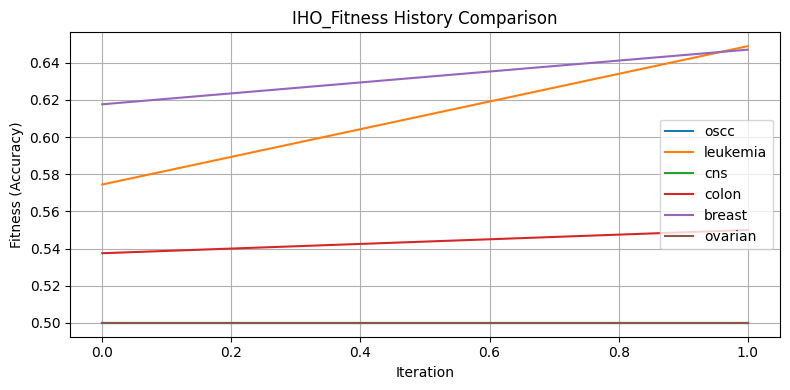

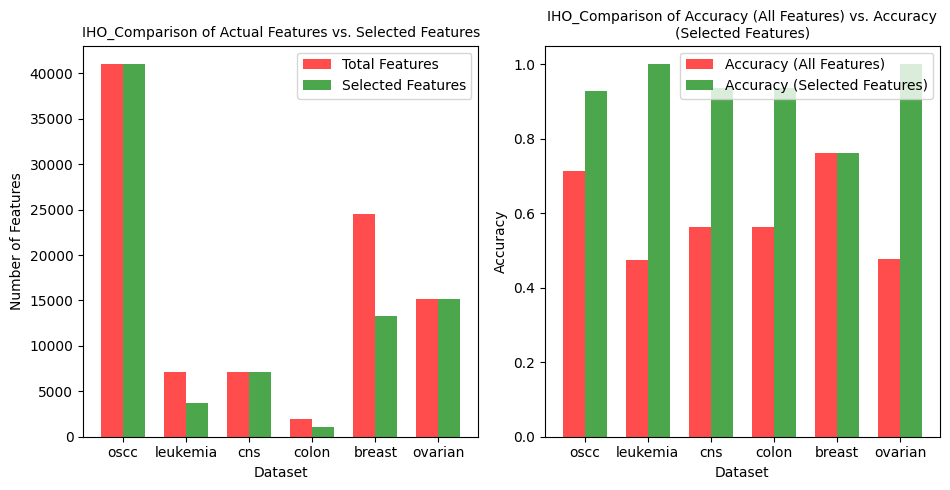

In [ ]:
# Assuming you have the preprocessed_dataframes dictionary
dataframes = {
    'oscc': oscc,
    'leukemia': leukemia,
    'cns': cns,
    'colon': colon,
    'breast': breast,
    'ovarian': ovarian
}

# Store results for comparison
results = {}
fitness_histories = {}  # Store fitness histories for each dataset

# Iterate through each dataset
for name, df in dataframes.items():
    print(f"Processing dataset: {name}")

    X = df.drop('Target', axis=1).values
    y = df['Target'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

    # Run optimization algorithm

    # best, best_fitness, fitness_history, best_intercept, f_name = DE(
    #     X, y, pop_size=50, max_iters=100, scaling_factor=0.5, crossover_probability=0.5, alpha=0.0)

    best, best_fitness, fitness_history, best_intercept, f_name = IHO(
        X, y, pop_size=50, max_iter=2, infection_rate=0.2, mutation_rate=0.3, a_max=2, alpha=0.0)

    # best, best_fitness, fitness_history, best_intercept, f_name = GWO(
    #     X, y, pop_size=50, max_iters=100, alpha=0.0)

    # best, best_fitness, fitness_history, best_intercept, f_name = HSA(
    #     X, y, pop_size=50, max_iters=100, l=0.08, LH=100, alpha=0.0)

    # best, best_fitness, fitness_history, best_intercept, f_name = PSO(
    #     X, y, pop_size=50, max_iters=100, c1=2, c2=2, v_max=6, w=1, alpha=0.0)

    # best, best_fitness, fitness_history, best_intercept, f_name = SCA(
    #     X, y, pop_size=50, max_iters=100, A=2, alpha=0.0)

    # best, best_fitness, fitness_history, best_intercept, f_name = SSA(
    #     X, y, pop_size=50, max_iters=100, c1_range=(0, 1), c2_range=(0, 1), alpha=0.0)

    # best, best_fitness, fitness_history, best_intercept, f_name = VCS(
    #     X, y, pop_size=50, max_iters=100, infection_rate=0.1, mutation_rate=0.2, alpha=0.0)

    # best, best_fitness, fitness_history, best_intercept, f_name = SHO(
    #     X, y, pop_size=50, max_iter=100, a=2, alpha=0.0)

    fitness_histories[name] = fitness_history

    intercept = list(best_intercept.keys())[0]
    y_pred = intercept + np.dot(X_test, best)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)

    # Feature Selection (Thresholding)
    threshold = 0.0  # Adjust as needed
    important_feature_indices = np.where(best > threshold)[0]

    # Check if any features were selected
    if len(important_feature_indices) == 0:
        print("No important features selected. Using all features.")
        important_features = df.columns[:-1]  # Use all features
    else:
        important_features = df.columns[:-1][important_feature_indices]
    # important_features = df.columns[:-1][important_feature_indices]

    # Create a new DataFrame with only the selected features
    X_selected = df[important_features]
    y = df['Target']
    X_train_selected, X_test_selected, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42)

    classifier = LogisticRegression()  # Initialize the classifier
    classifier.fit(X_train_selected, y_train)  # Train the classifier
    y_pred_selected = classifier.predict(X_test_selected)
    accuracy_selected = accuracy_score(y_test, y_pred_selected)

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'accuracy_selected': accuracy_selected,
        'num_features': len(important_features)
    }

# Change function name as per the algorithm
function = f_name

# Create DataFrame for fitness histories
fitness_df = pd.DataFrame(fitness_histories)
fitness_df.index.name = 'Iteration'  # Set index name
fitness_df.to_csv(f'{function}_fitness_histories.csv')  # Save to CSV

# Create DataFrame for selected features and accuracy
results_df = pd.DataFrame(results).T  # Transpose for better structure
results_df.to_csv(f'{function}_feature_selection_results.csv')  # Save to CSV

# Plot fitness histories using Seaborn
plt.figure(figsize=(8, 4))  # Reduced figure size
sns.lineplot(data=fitness_df, dashes=False)  # fitness_df was created earlier
plt.title(f'{function}_Fitness History Comparison')
plt.xlabel('Iteration')
plt.ylabel('Fitness (Accuracy)')
plt.grid()
plt.legend()
plt.tight_layout()  # Adjusts subplot params for a tight layout
plt.show()

# Comparison of features and accuracies in subplots

total_features = [df.shape[1] - 1 for df in dataframes.values()]
selected_features = [result['num_features'] for result in results.values()]
accuracy_all = [result['accuracy'] for result in results.values()]
accuracy_selected = [result['accuracy_selected'] for result in results.values()]

# Calculate figure width based on the number of datasets
fig_width = len(dataframes) * 0.8  # Adjust the multiplier as needed

# Create a figure and an array of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width * 2, 5))  # Adjust figsize as needed

# Font dictionary for reduced font size
fontdict = {'fontsize': 10}  # Adjust the fontsize value as needed

bar_width = 0.35
index = np.arange(len(dataframes))

# Plot 1: Comparison of Actual Features vs. Selected Features
axes[0].bar(index, total_features, bar_width, label='Total Features', alpha=0.7, color='red')
axes[0].bar(index + bar_width, selected_features, bar_width, label='Selected Features', alpha=0.7, color='green')

title = f'{function}_Comparison of Actual Features vs. Selected Features'
wrapped_title = "\n".join(textwrap.wrap(title, 60))  # Wrap to 60 characters
axes[0].set_title(wrapped_title, fontdict=fontdict)
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Number of Features')
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(dataframes.keys())
axes[0].legend()

# Plot 2: Comparison of Accuracy (All Features) vs. Accuracy (Selected Features)
axes[1].bar(index, accuracy_all, bar_width, label='Accuracy (All Features)', alpha=0.7, color='red')
axes[1].bar(index + bar_width, accuracy_selected, bar_width, label='Accuracy (Selected Features)', alpha=0.7, color='green')

title = f'{function}_Comparison of Accuracy (All Features) vs. Accuracy (Selected Features)'
wrapped_title = "\n".join(textwrap.wrap(title, 60))  # Wrap to 60 characters
axes[1].set_title(wrapped_title, fontdict=fontdict)
axes[1].set_xlabel('Dataset')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(index + bar_width / 2)
axes[1].set_xticklabels(dataframes.keys())
axes[1].legend()

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

# Performance comparision between the algorithms

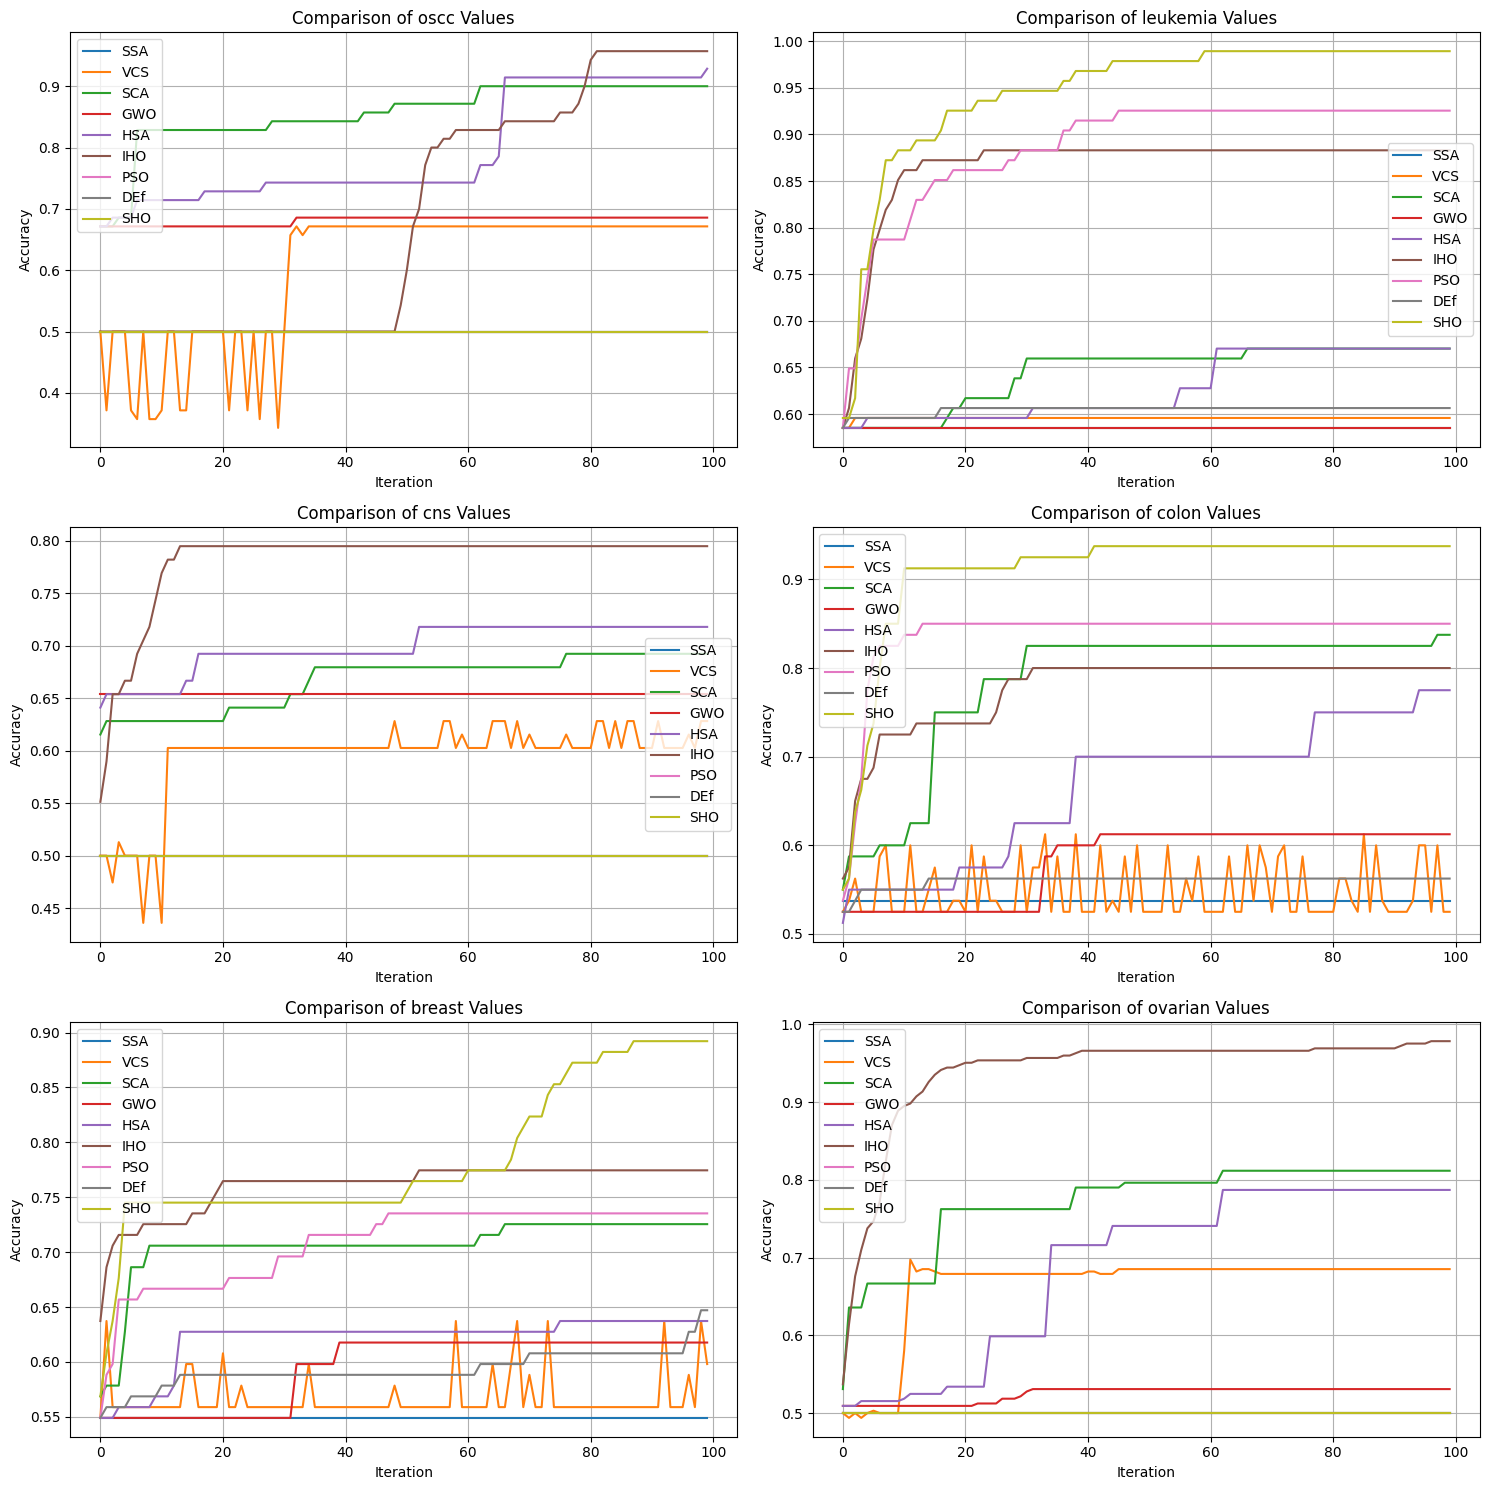

In [ ]:
# Specify the directory containing the CSV files
directory = "/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Fitness_history"

# Create an empty dictionary to store the dataframes
dfs = {}

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        try:
            # Extract algorithm name from filename (first 2-3 letters before "_")
            algorithm_name = "".join([char for char in filename if char.isalpha()][:3])

            # Read the CSV file into a pandas dataframe
            df = pd.read_csv(filepath)

            # Replace negative values with 0 for all columns
            df[df < 0] = 0

            # Store the entire dataframe in the dictionary
            dfs[algorithm_name] = df

        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")

# Create a list to store comparison dataframes for each dataset
comparison_dfs = []

# Check if any dataframes were successfully read
if dfs:
    # Get the common datasets (column names) from the first dataframe, excluding 'Iteration'
    datasets = [col for col in dfs[list(dfs.keys())[0]].columns if col != 'Iteration']

    # Create a figure and an array of subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  # Adjust figsize as needed

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Plot the line graphs for each dataset in subplots
    for i, dataset in enumerate(datasets):
        dataset_data = {}
        for algorithm_name, df in dfs.items():
            if dataset in df.columns:
                dataset_data[algorithm_name] = df[dataset]
        comparison_df = pd.DataFrame(dataset_data)

        # Save the dataframe to a CSV file
        comparison_df.to_csv(f"{dataset}_comparison.csv", index=False)

        for column in comparison_df.columns:
            axes[i].plot(comparison_df.index, comparison_df[column], label=column)
        axes[i].set_xlabel("Iteration")
        axes[i].set_ylabel("Accuracy")
        axes[i].set_title(f"Comparison of {dataset} Values")
        axes[i].legend()
        axes[i].grid(True)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()
else:
    print("No valid CSV files found in the specified directory.")

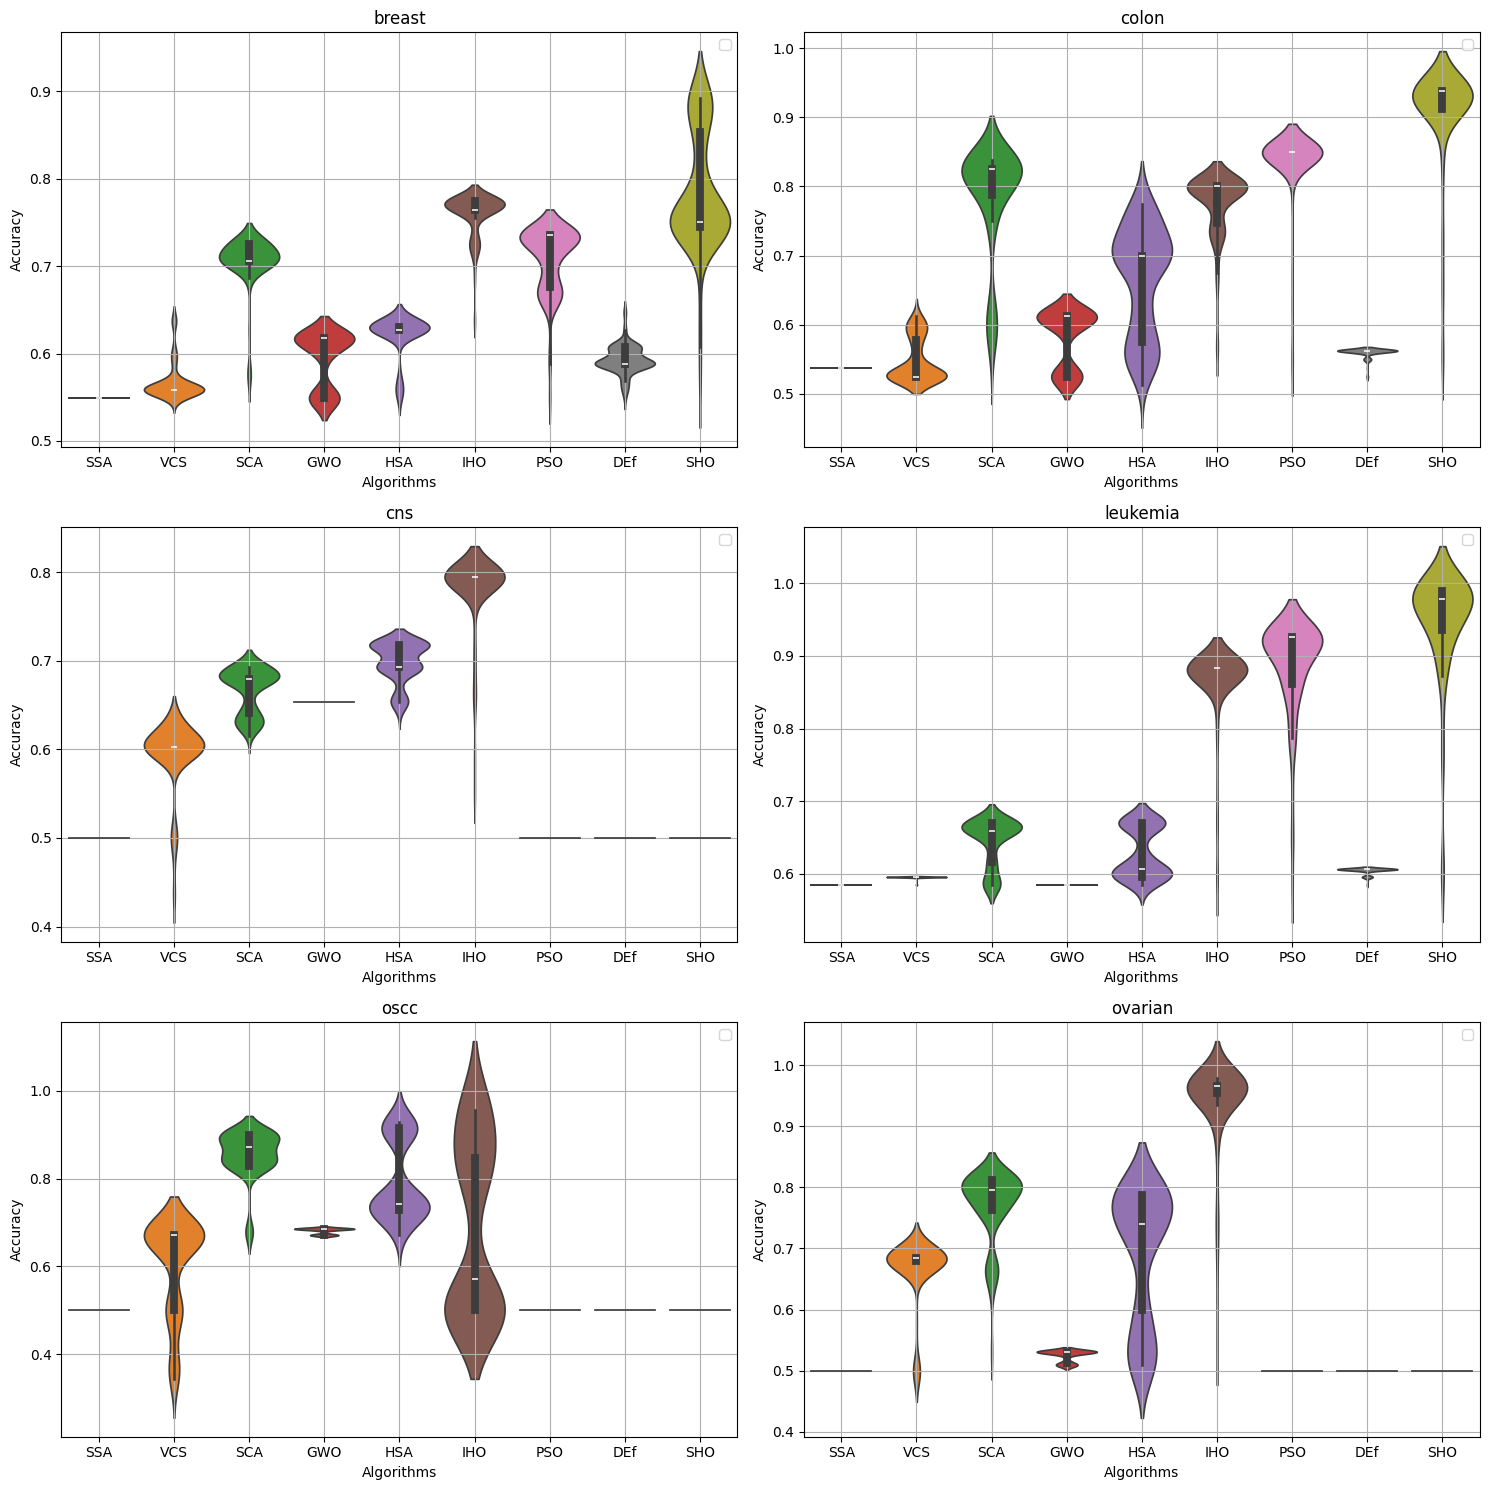

In [ ]:
# Specify the directory containing the CSV files
directory = "/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Algorithm_comparision"

# Create a figure and an array of subplots (3x2 grid)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Iterate through each file in the directory
for i, filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        try:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(filepath)
            # Create a violin plot for the first numeric column
            sns.violinplot(data=df, ax=axes[i])
            # Extract dataset name from filename
            dataset_name = filename.split("_")[0]
            axes[i].set_title(dataset_name)
            axes[i].set_xlabel("Algorithms")
            axes[i].set_ylabel("Accuracy")
            axes[i].legend()
            axes[i].grid(True)

        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")

    # If we've filled all subplots, break the loop
    if i == len(axes) - 1:
        break
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

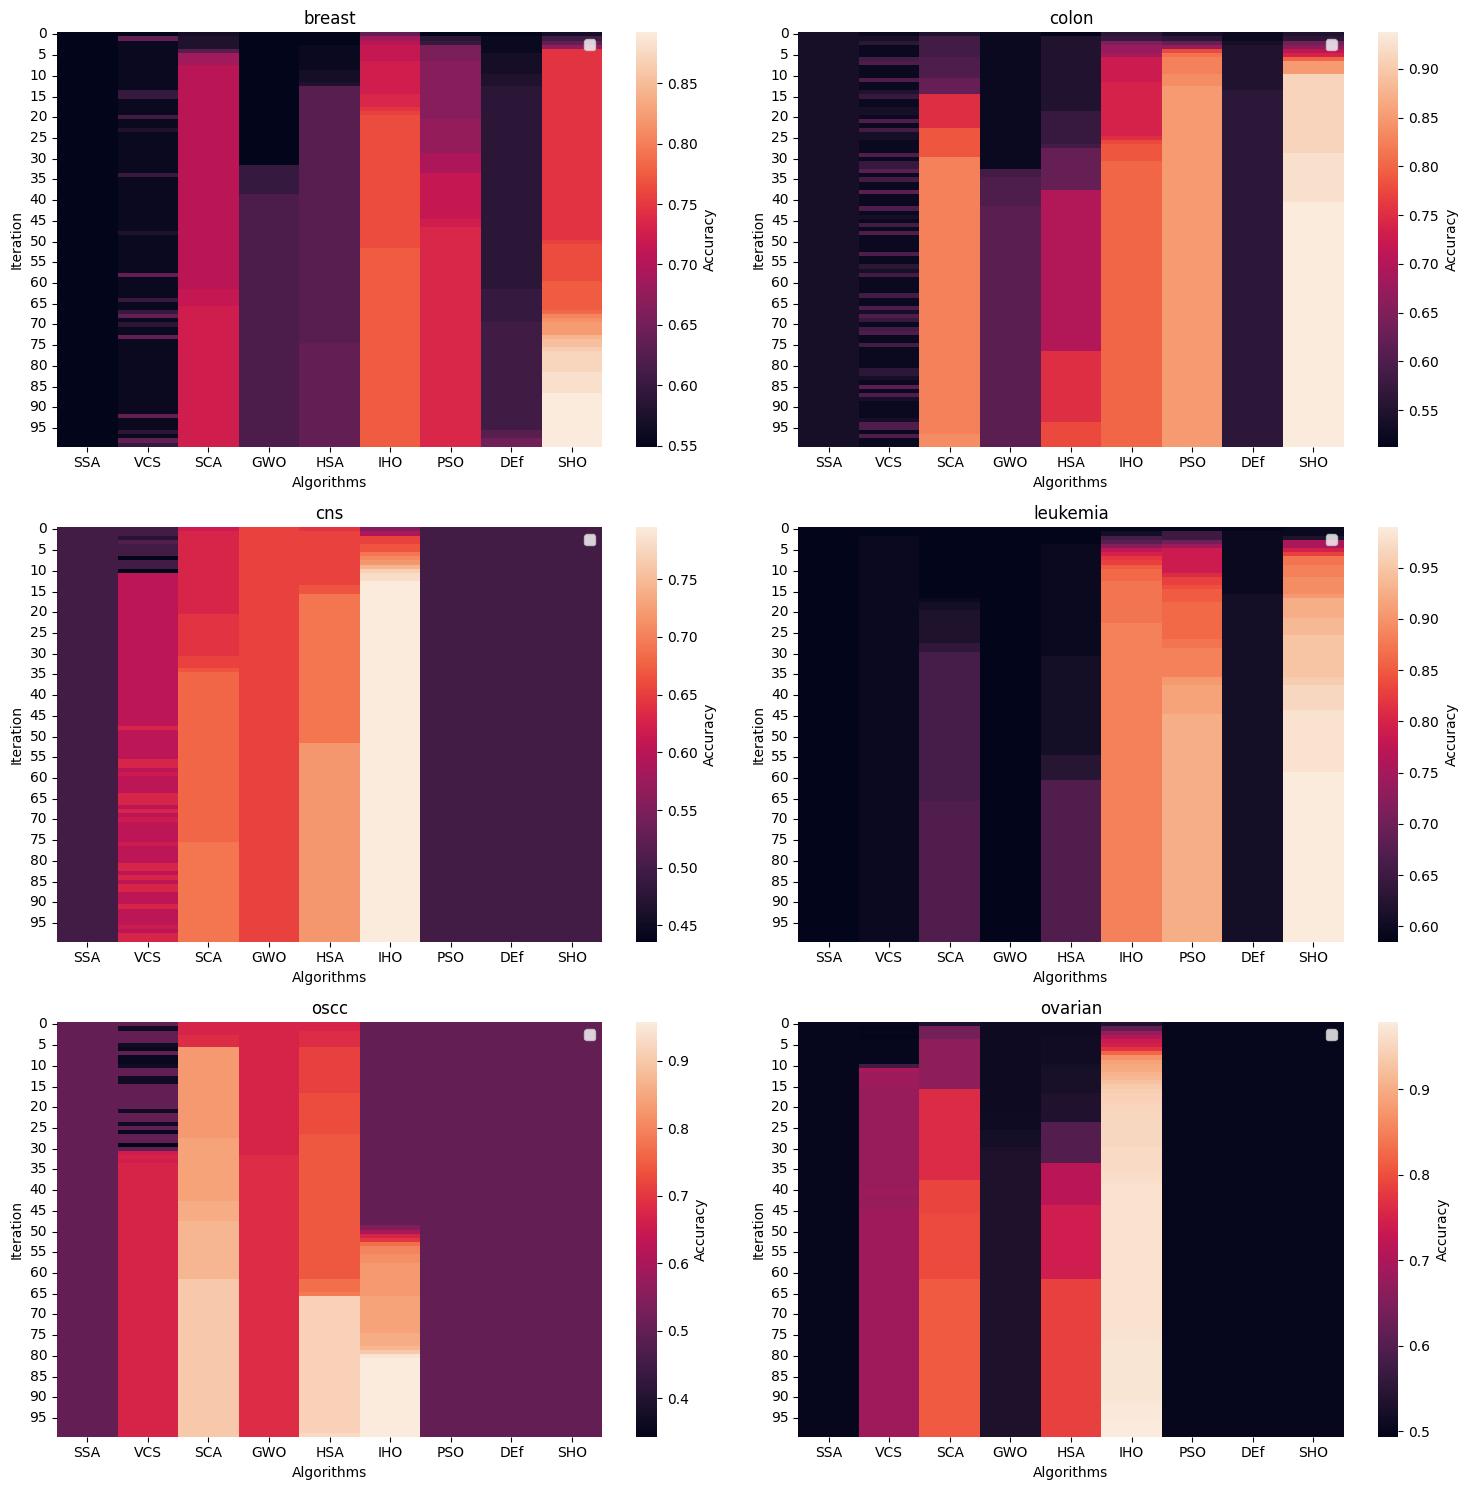

In [ ]:
# Specify the directory containing the CSV files
directory = "/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Algorithm_comparision"

# Create a figure and an array of subplots (3x2 grid)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Iterate through each file in the directory
for i, filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        try:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(filepath)
            # Create a violin plot for the first numeric column
            sns.heatmap(data=df, ax=axes[i], cbar_kws={'label': 'Accuracy'})
            # Extract dataset name from filename
            dataset_name = filename.split("_")[0]
            axes[i].set_title(dataset_name)
            axes[i].set_xlabel("Algorithms")
            axes[i].set_ylabel("Iteration")
            axes[i].legend()
            # axes[i].grid(True)

        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")

    # If we've filled all subplots, break the loop
    if i == len(axes) - 1:
        break
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

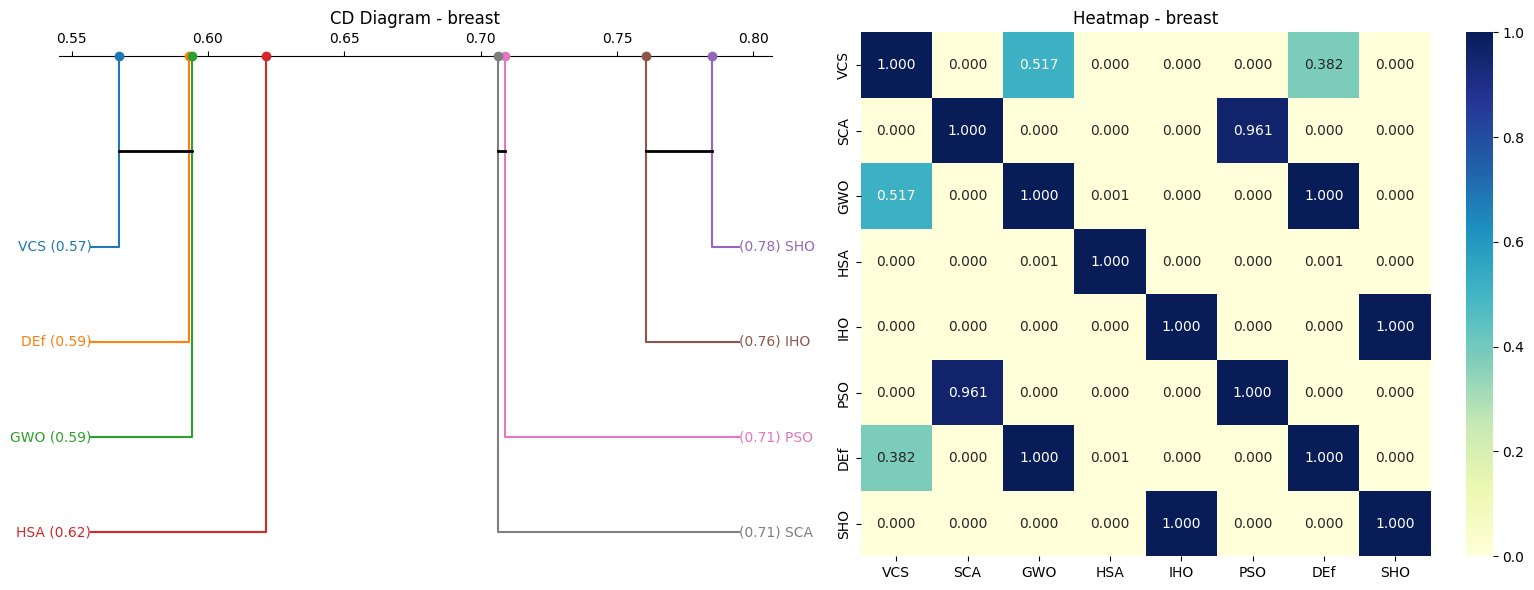

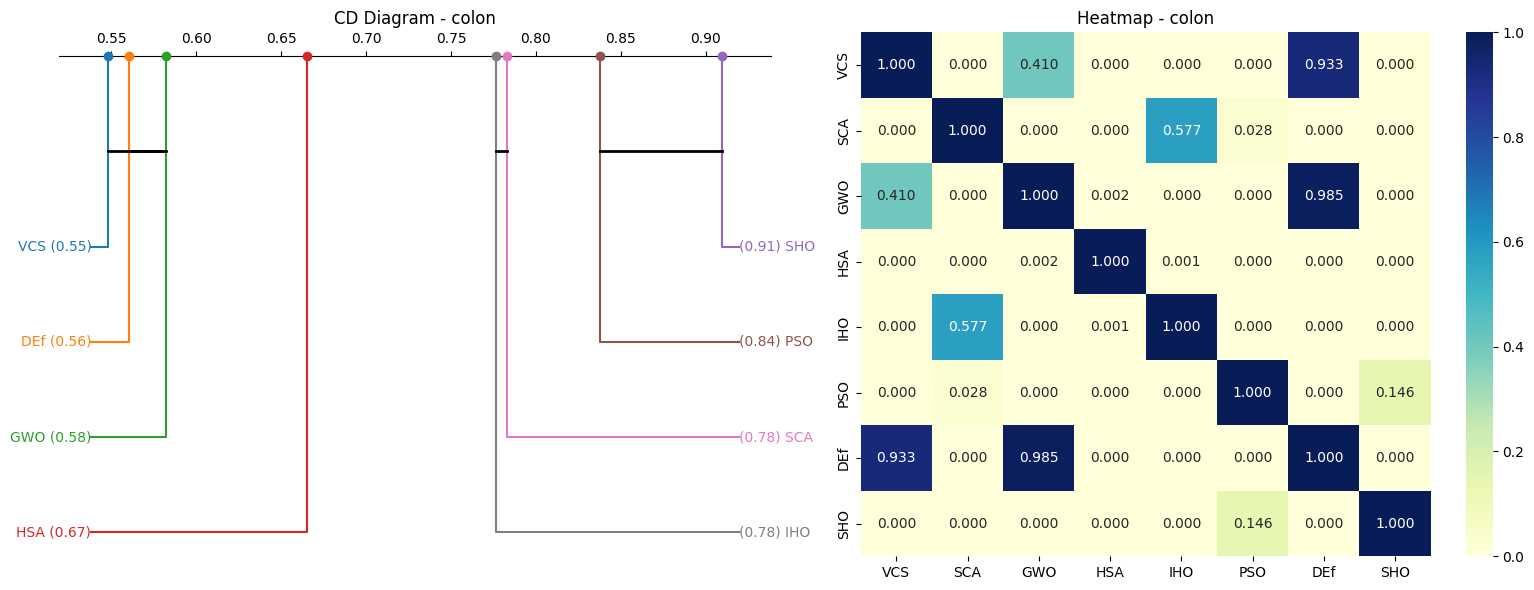

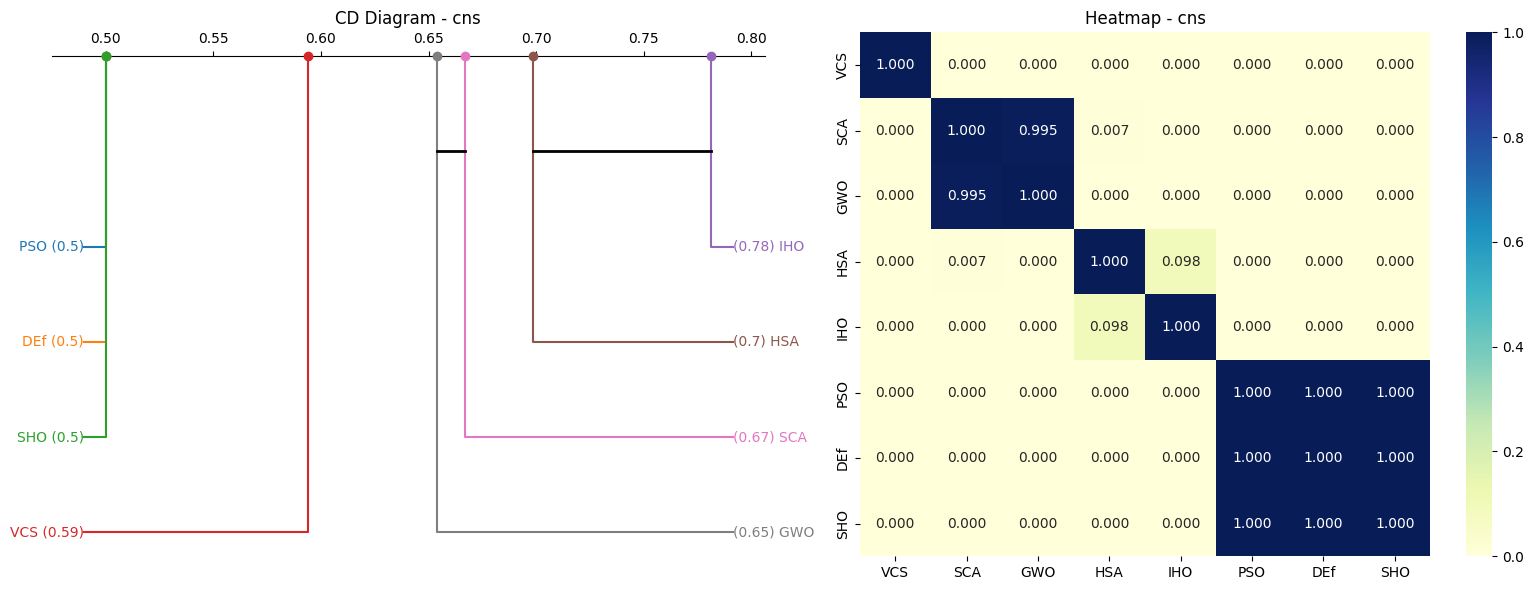

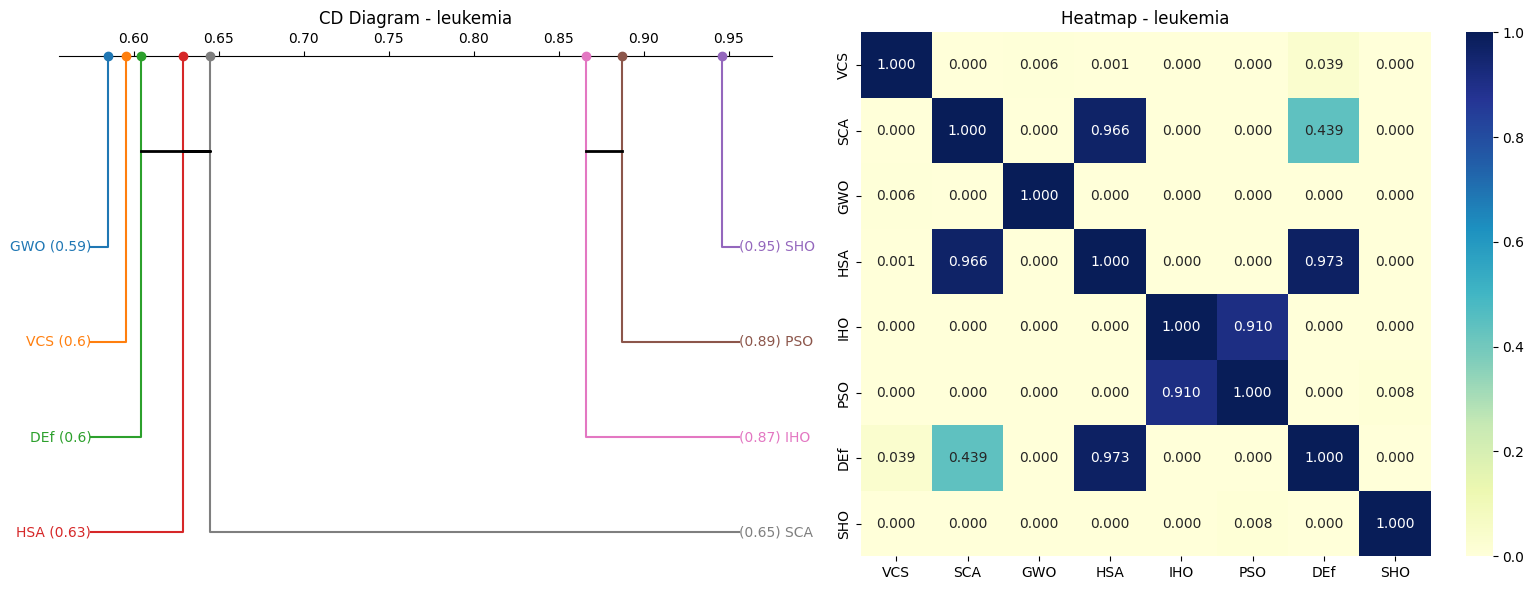

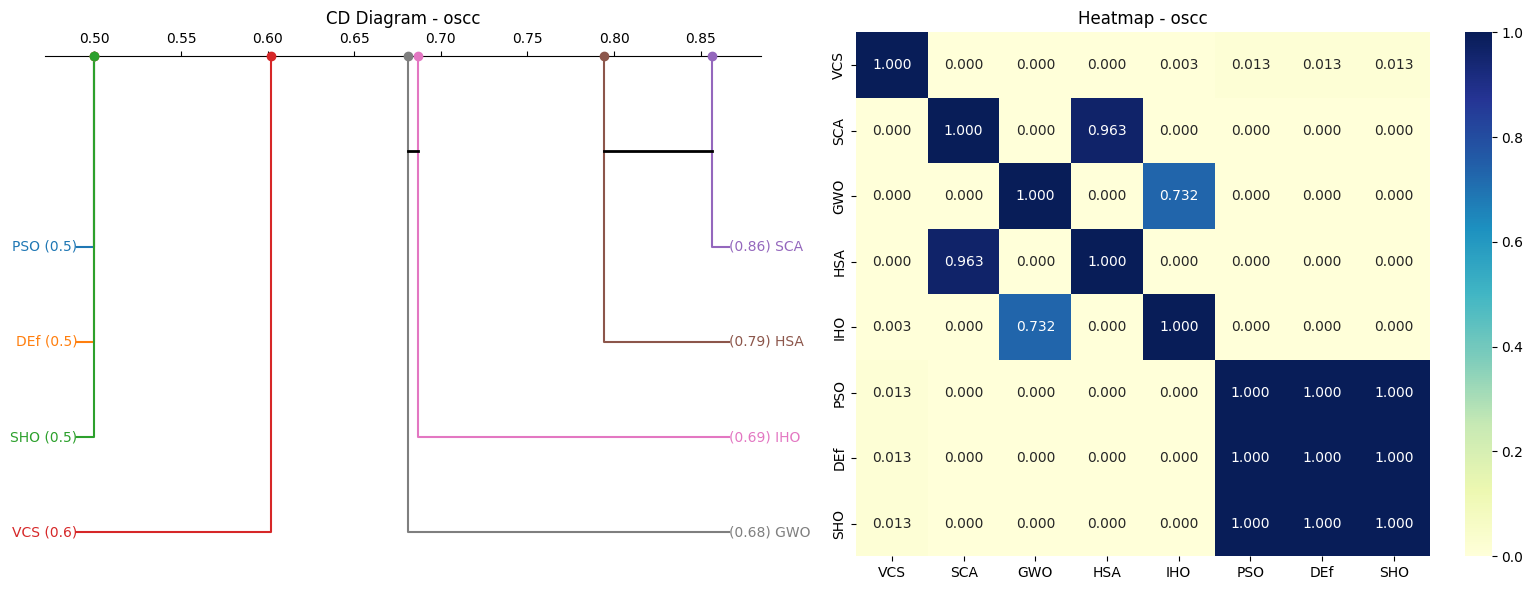

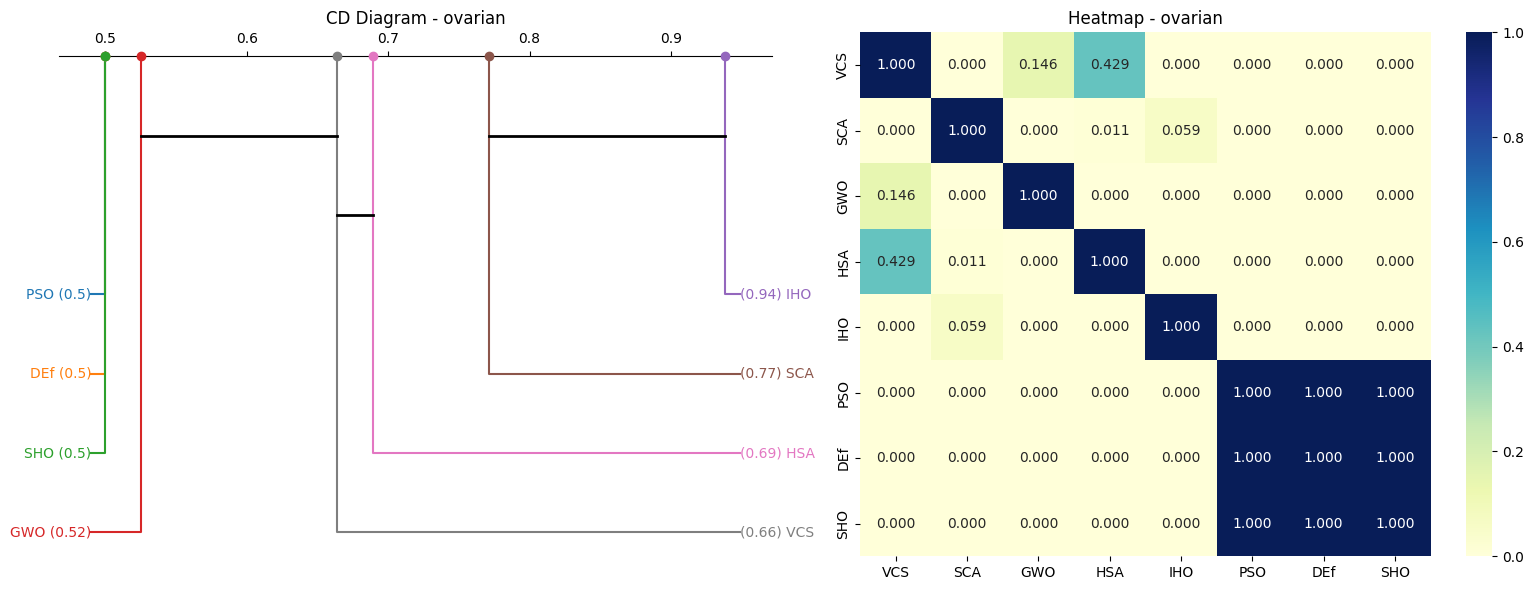

In [ ]:
# Specify the directory containing the CSV files
directory = "/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Algorithm_comparision"  # Update with your directory path

# Create lists to store results
friedman_results = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        try:
            # Load the data
            df = pd.read_csv(filepath)

            # Perform the Friedman test
            algorithms = df.columns[1:]
            data = df[algorithms].values.T
            statistic, p_value = friedmanchisquare(*data)

            # Store Friedman test results
            friedman_results.append([filename, statistic, p_value])

            # Perform the Nemenyi post-hoc test
            posthoc_nemenyi = sp.posthoc_nemenyi_friedman(df[algorithms])

            # Calculate average ranks for each algorithm
            average_ranks = df[algorithms].mean()

            dataset_name = filename.split("_")[0]  # Extract dataset name from filename

            # Create CD Diagram and Heatmap directly in subplots
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns for CD and Heatmap

            # CD Diagram
            sp.critical_difference_diagram(average_ranks, sig_matrix=posthoc_nemenyi, ax=axes[0])
            axes[0].set_title(f"CD Diagram - {dataset_name}")

            # Heatmap
            sns.heatmap(posthoc_nemenyi, annot=True, cmap="YlGnBu", fmt=".3f", ax=axes[1])
            axes[1].set_title(f"Heatmap - {dataset_name}")

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")

# Create DataFrame for Friedman test results
friedman_df = pd.DataFrame(friedman_results, columns=["Dataset", "Statistic", "P-value"])

# Add hypothesis test result column
friedman_df["Hypothesis"] = np.where(friedman_df["P-value"] < 0.05, "Reject Null Hypothesis", "Fail to Reject Null Hypothesis")

# Save Friedman test results to CSV
friedman_df.to_csv("friedman_test_results.csv", index=False)

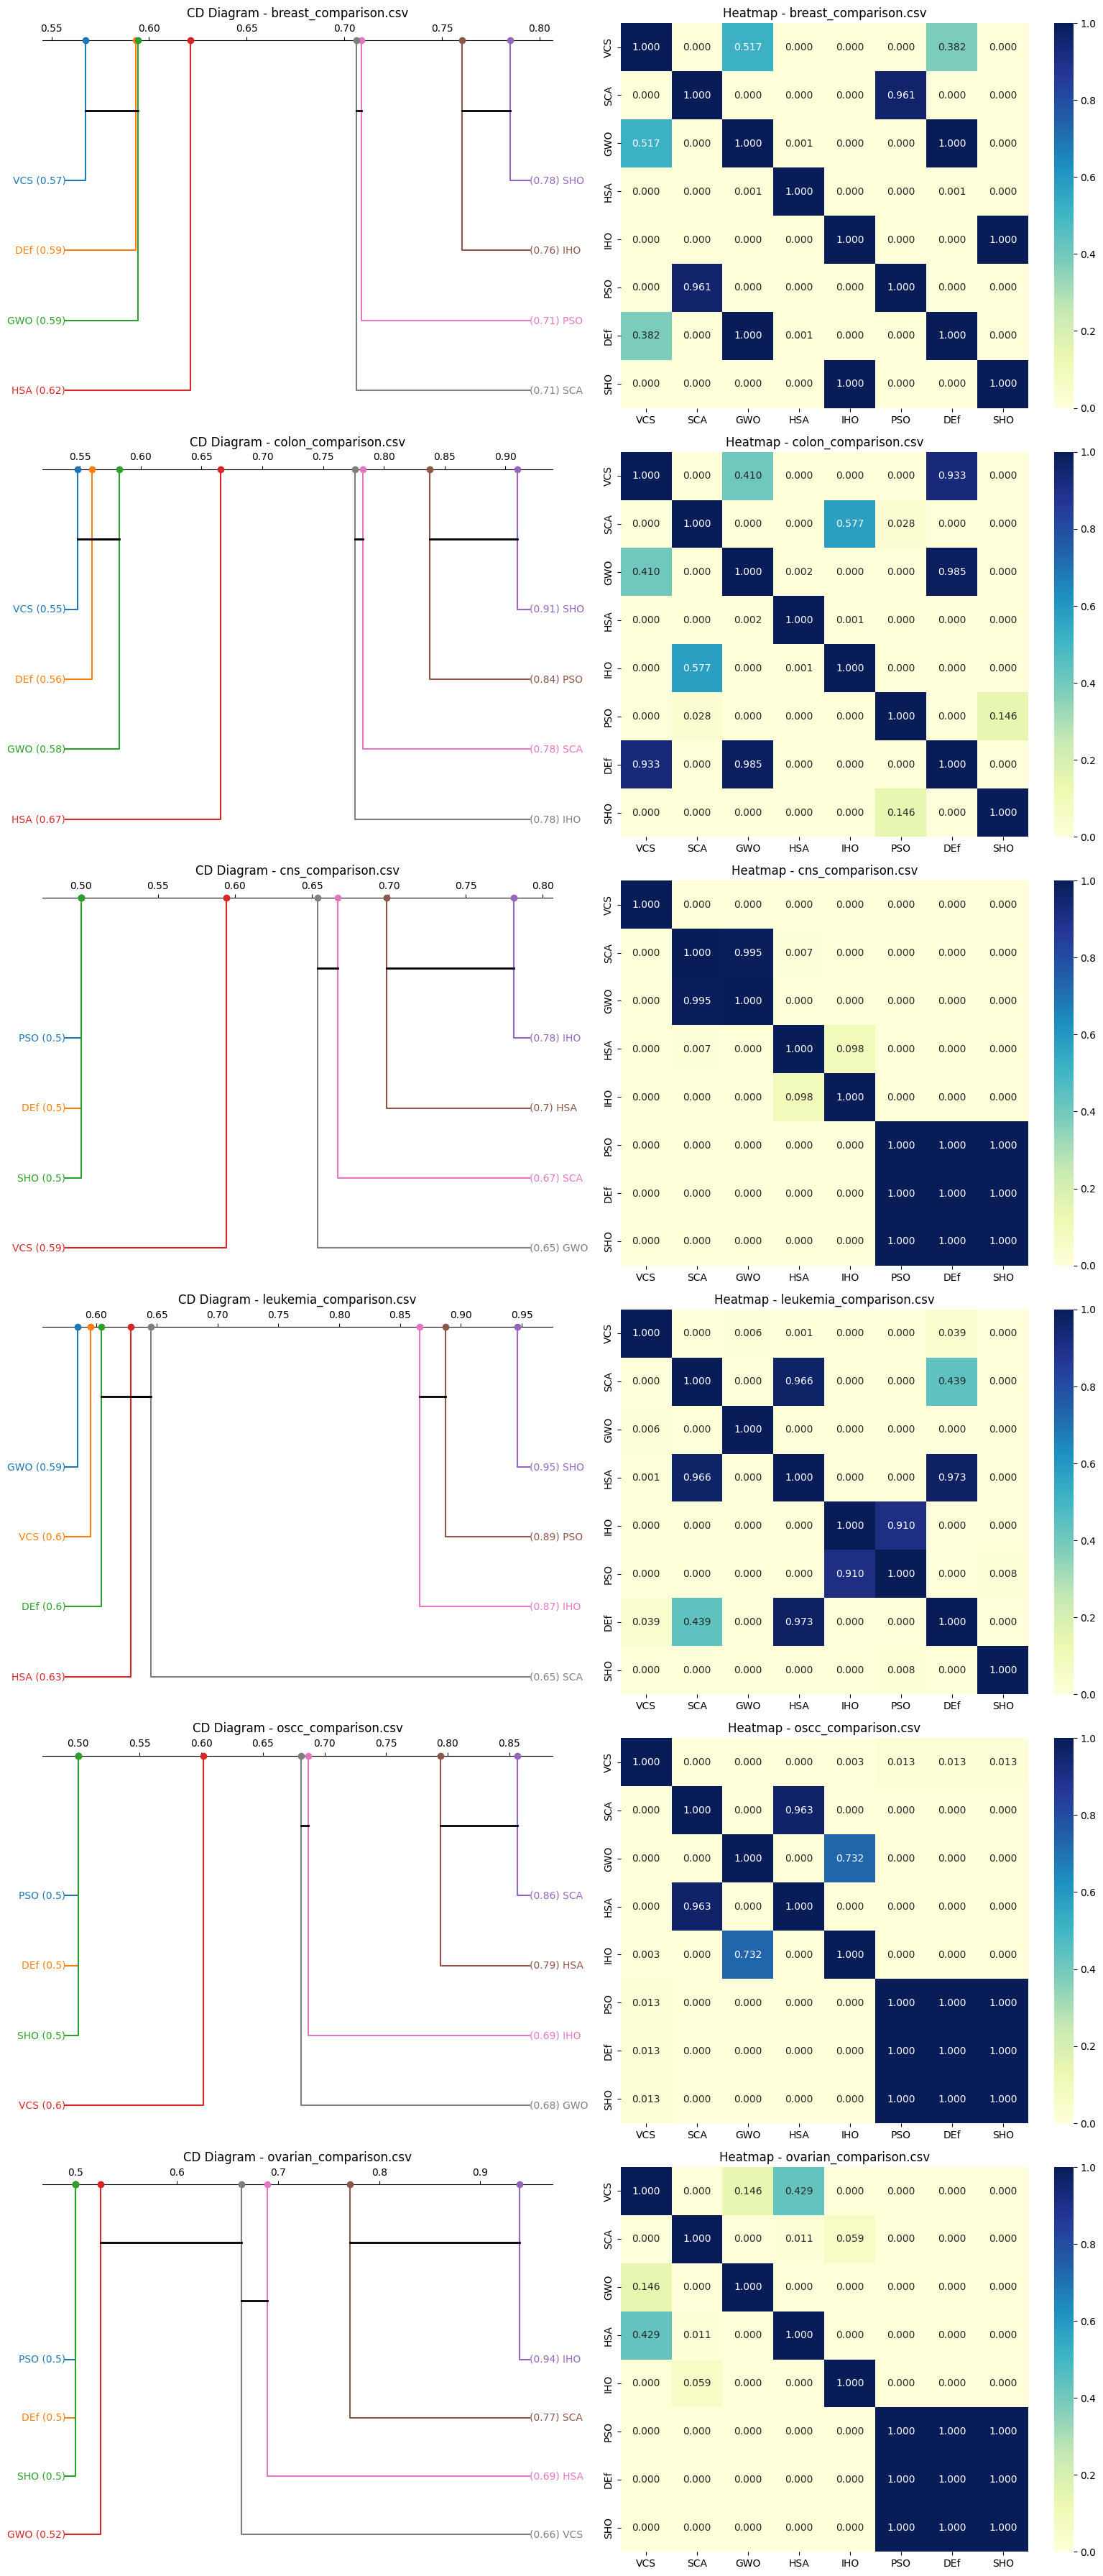

In [ ]:
# Specify the directory containing the CSV files
directory = "/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Algorithm_comparision"  # Update with your directory path

# Create lists to store results
friedman_results = []

# Get the datasets from CSV files in the directory
datasets = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        dataset_name = filename[:-4]  # Remove ".csv" extension
        datasets.append(dataset_name)

# Create a figure and a grid of subplots
num_datasets = len(datasets)
fig, axes = plt.subplots(num_datasets, 2, figsize=(16, num_datasets * 6))  # Adjust figsize as needed

# Flatten the axes array for easier iteration if num_datasets > 1
if num_datasets > 1:
    axes = axes.flatten()

# Loop through each file/dataset
for i, (dataset, filename) in enumerate(zip(datasets, os.listdir(directory))):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        try:
            # Load the data
            df = pd.read_csv(filepath)

            # Perform the Friedman test
            algorithms = df.columns[1:]
            data = df[algorithms].values.T
            statistic, p_value = friedmanchisquare(*data)

            # Store Friedman test results
            friedman_results.append([filename, statistic, p_value])

            # Perform the Nemenyi post-hoc test
            posthoc_nemenyi = sp.posthoc_nemenyi_friedman(df[algorithms])

            # Calculate average ranks for each algorithm
            average_ranks = df[algorithms].mean()

            # Get the correct axes for this dataset
            row = i  # Row index for this dataset
            ax_cd = axes[row * 2] if num_datasets > 1 else axes[0]  # CD diagram axis
            ax_heatmap = axes[row * 2 + 1] if num_datasets > 1 else axes[1]  # Heatmap axis

            # CD Diagram
            sp.critical_difference_diagram(average_ranks, sig_matrix=posthoc_nemenyi, ax=ax_cd)
            ax_cd.set_title(f"CD Diagram - {filename}")

            # Heatmap
            sns.heatmap(posthoc_nemenyi, annot=True, cmap="YlGnBu", fmt=".3f", ax=ax_heatmap)
            ax_heatmap.set_title(f"Heatmap - {filename}")

        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# Create DataFrame for Friedman test results
friedman_df = pd.DataFrame(friedman_results, columns=["Dataset", "Statistic", "P-value"])

# Add hypothesis test result column
friedman_df["Hypothesis"] = np.where(friedman_df["P-value"] < 0.05, "Reject Null Hypothesis", "Fail to Reject Null Hypothesis")

# Save Friedman test results to CSV
friedman_df.to_csv("friedman_test_results.csv", index=False)

In [ ]:
# prompt: take each file from /content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection and create one csv file for OSCC dataset when rows will be the algorithm, accuracy_selected, and num_features

import pandas as pd
import os

# Define the input and output directories
input_dir = "/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection"
output_file = "/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/OSCC_feature_selection.csv"

# Create an empty list to store the data
data = []

# Iterate through each file in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):  # Check if the file is for the OSCC dataset
        filepath = os.path.join(input_dir, filename)
        try:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(filepath)

            # Extract the algorithm name from the filename (assuming the algorithm name is before the first "_")
            algorithm_name = filename.split("_")[0]

            # Extract accuracy_selected and num_features (adjust column names if needed)
            accuracy_selected = df['accuracy_selected'].iloc[0] if 'accuracy_selected' in df.columns else None
            num_features = df['num_features'].iloc[0] if 'num_features' in df.columns else None

            # Append the data to the list
            data.append([algorithm_name, accuracy_selected, num_features])

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# Create a DataFrame from the collected data
if data:
    df_results = pd.DataFrame(data, columns=["Algorithm", "Accuracy_Selected", "Num_Features"])

    # Save the DataFrame to a CSV file
    df_results.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
else:
    print("No files found for OSCC dataset or an error occurred")

Results saved to /content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/OSCC_feature_selection.csv


In [ ]:
# Specify the directory containing the CSV files
directory = "/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection"

# Create an empty dictionary to store the dataframes
dfs = {}

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        try:
            # Extract algorithm name from filename (first 2-3 letters before "_")
            algorithm_name = filename.split("_")[0]

            # Read the CSV file into a pandas dataframe
            df = pd.read_csv(filepath)

            # Store the entire dataframe in the dictionary
            dfs[algorithm_name] = df

        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")

# Create a list to store comparison dataframes for each dataset
comparison_dfs = []

# Check if any dataframes were successfully read
if dfs:
    # Get the common datasets (column names) from the first dataframe, excluding 'Iteration'
    datasets = [col for col in dfs[list(dfs.keys())[0]].columns if col != 'Iteration']

    # Plot the line graphs for each dataset in subplots
    for i, dataset in enumerate(datasets):
        dataset_data = {}
        for algorithm_name, df in dfs.items():
            if dataset in df.columns:
                dataset_data[algorithm_name] = df[dataset]
        comparison_df = pd.DataFrame(dataset_data)

        # Save the dataframe to a CSV file
        comparison_df.to_csv(f"{dataset}_FS.csv", index=False)
else:
    print("No valid CSV files found in the specified directory.")

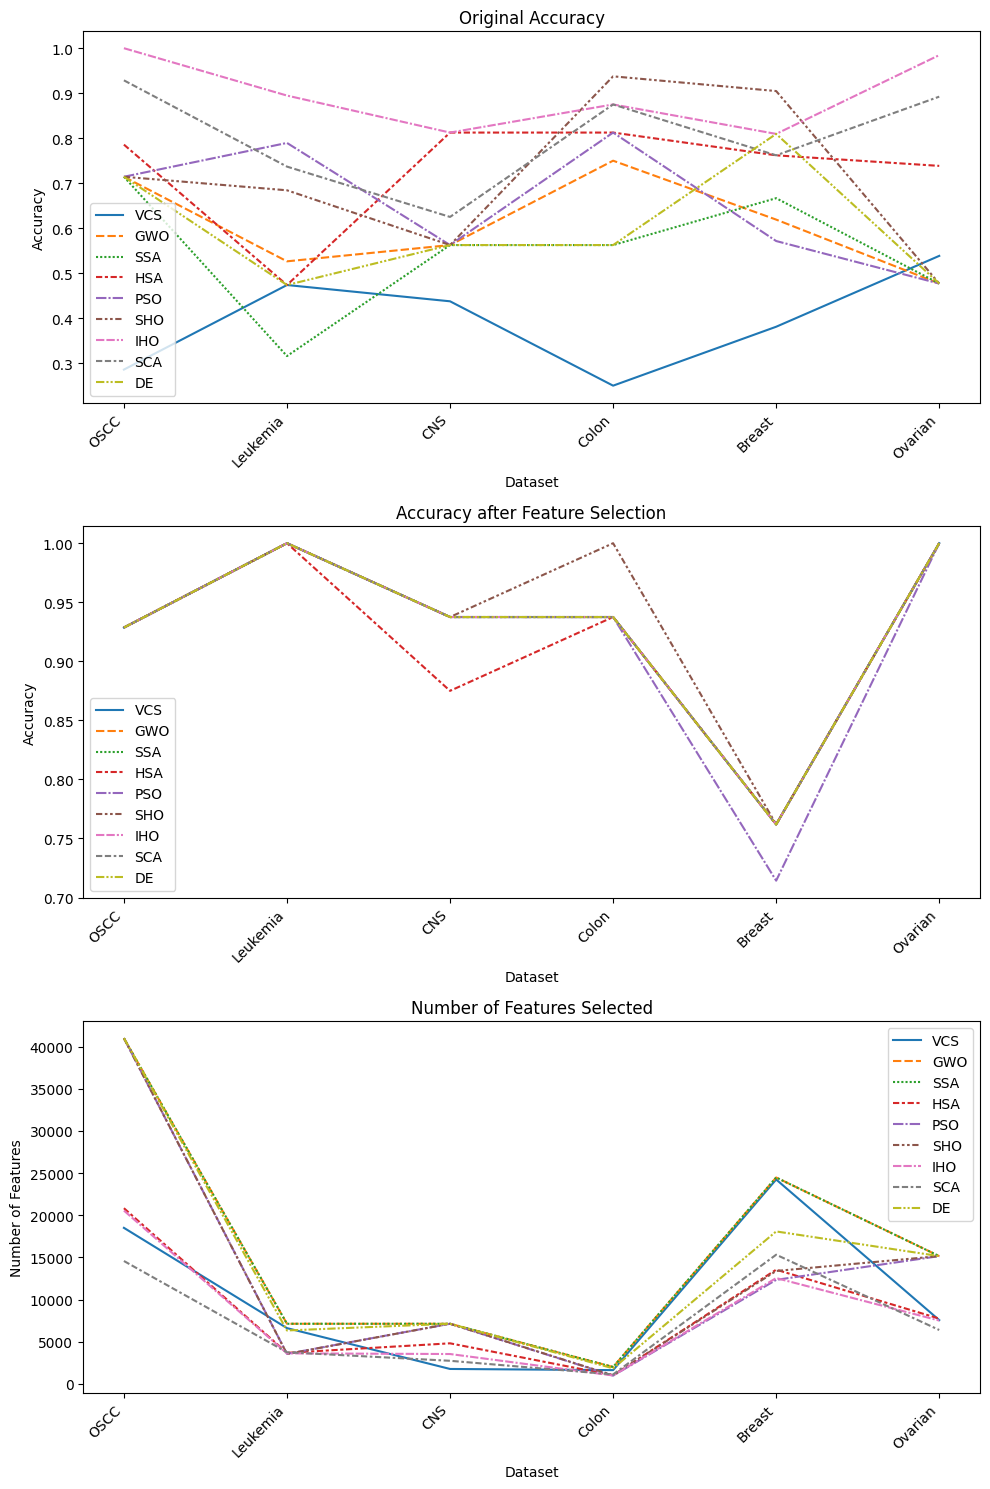

In [ ]:
accuracy_ori = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/accuracy_FS.csv')
accuracy_sel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/accuracy_selected_FS.csv')
num_sel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/num_features_FS.csv')

# Assuming accuracy_ori, accuracy_sel, and num_sel are already loaded, and 'Dataset' is the first column
datasets = accuracy_ori['Dataset'].unique()  # Get unique dataset names

# Create subplots with 3 rows and 1 column
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # Adjust figsize as needed

# Plot 1: Original Accuracy
sns.lineplot(data=accuracy_ori, ax=axes[0])
axes[0].set_title('Original Accuracy')
axes[0].set_xlabel('Dataset')  # Changed to 'Dataset'
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(len(datasets)))  # Set x-tick positions
axes[0].set_xticklabels(datasets, rotation=45, ha='right')  # Set x-tick labels

# Plot 2: Accuracy after Feature Selection
sns.lineplot(data=accuracy_sel, ax=axes[1])
axes[1].set_title('Accuracy after Feature Selection')
axes[1].set_xlabel('Dataset')  # Changed to 'Dataset'
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(range(len(datasets)))  # Set x-tick positions
axes[1].set_xticklabels(datasets, rotation=45, ha='right')  # Set x-tick labels

# Plot 3: Number of Features Selected
sns.lineplot(data=num_sel, ax=axes[2])
axes[2].set_title('Number of Features Selected')
axes[2].set_xlabel('Dataset')  # Changed to 'Dataset'
axes[2].set_ylabel('Number of Features')
axes[2].set_xticks(range(len(datasets)))  # Set x-tick positions
axes[2].set_xticklabels(datasets, rotation=45, ha='right')  # Set x-tick labels

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
accuracy_ori = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/accuracy_FS.csv')
accuracy_sel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/accuracy_selected_FS.csv')
num_sel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/num_features_FS.csv')

# Concatenate the DataFrames along the columns (axis=1)
all_accuracy = pd.concat([accuracy_ori, accuracy_sel], axis=1)

# Optional: Add a suffix to the column names to distinguish between original and selected accuracy
all_accuracy = pd.concat([accuracy_ori, accuracy_sel.add_suffix('_sel')], axis=1)
all_accuracy.drop(columns=['Dataset_sel'], inplace=True)

# Display or save the concatenated DataFrame
print(all_accuracy)
# all_accuracy.to_csv('all_accuracy.csv', index=False)  # To save to a CSV file

    Dataset       VCS       GWO       SSA       HSA       PSO       SHO  \
0      OSCC  0.285714  0.714286  0.714286  0.785714  0.714286  0.714286   
1  Leukemia  0.473684  0.526316  0.315789  0.473684  0.789474  0.684211   
2       CNS  0.437500  0.562500  0.562500  0.812500  0.562500  0.562500   
3     Colon  0.250000  0.750000  0.562500  0.812500  0.812500  0.937500   
4    Breast  0.380952  0.619048  0.666667  0.761905  0.571429  0.904762   
5   Ovarian  0.538462  0.476923  0.476923  0.738462  0.476923  0.476923   

        IHO       SCA        DE   VCS_sel   GWO_sel   SSA_sel   HSA_sel  \
0  1.000000  0.928571  0.714286  0.928571  0.928571  0.928571  0.928571   
1  0.894737  0.736842  0.473684  1.000000  1.000000  1.000000  1.000000   
2  0.812500  0.625000  0.562500  0.937500  0.937500  0.937500  0.875000   
3  0.875000  0.875000  0.562500  0.937500  0.937500  0.937500  0.937500   
4  0.809524  0.761905  0.809524  0.761905  0.761905  0.761905  0.761905   
5  0.984615  0.892308  0

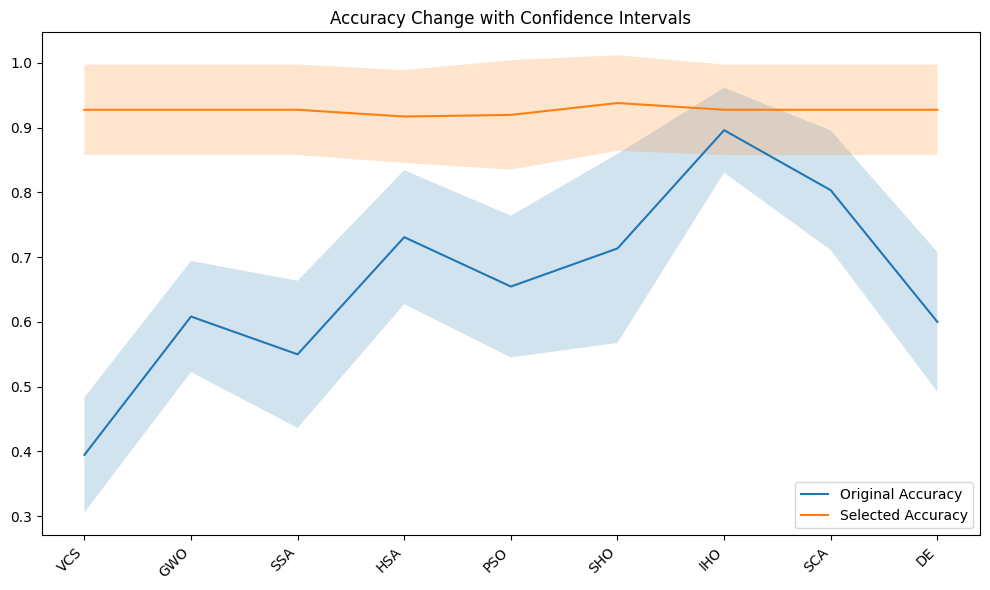

In [ ]:
accuracy_ori = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/accuracy_FS.csv')
accuracy_sel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/accuracy_selected_FS.csv')
num_sel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/num_features_FS.csv')

datasets = accuracy_ori['Dataset'].unique()  # Get unique dataset names

# Calculate mean and confidence intervals
# Assuming your accuracy data is in columns named like 'DE', 'IHO', etc.
algorithms = accuracy_ori.columns[1:]  # Get algorithm names (excluding 'Dataset')

mean_original_accuracy = accuracy_ori[algorithms].mean()
mean_selected_accuracy = accuracy_sel[algorithms].mean()

# Calculate confidence intervals (using standard error here as an example)
std_original_accuracy = accuracy_ori[algorithms].std()
std_selected_accuracy = accuracy_sel[algorithms].std()

# Assuming a 95% confidence interval (z-score of 1.96)
lower_ci_original = mean_original_accuracy - 1.96 * std_original_accuracy / np.sqrt(len(accuracy_ori))
upper_ci_original = mean_original_accuracy + 1.96 * std_original_accuracy / np.sqrt(len(accuracy_ori))
lower_ci_selected = mean_selected_accuracy - 1.96 * std_selected_accuracy / np.sqrt(len(accuracy_sel))
upper_ci_selected = mean_selected_accuracy + 1.96 * std_selected_accuracy / np.sqrt(len(accuracy_sel))


plt.figure(figsize=(10, 6))
# The x-axis needs to correspond to the algorithms, not the datasets
# Since you are plotting the mean accuracy for each algorithm across datasets
x_axis = range(len(algorithms))  # Create an x-axis for the algorithms

plt.plot(x_axis, mean_original_accuracy.values, label='Original Accuracy')
plt.fill_between(x_axis, lower_ci_original.values, upper_ci_original.values, alpha=0.2)
plt.plot(x_axis, mean_selected_accuracy.values, label='Selected Accuracy')
plt.fill_between(x_axis, lower_ci_selected.values, upper_ci_selected.values, alpha=0.2)
plt.title('Accuracy Change with Confidence Intervals')

# Set algorithm names as x-axis labels
plt.xticks(x_axis, algorithms, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

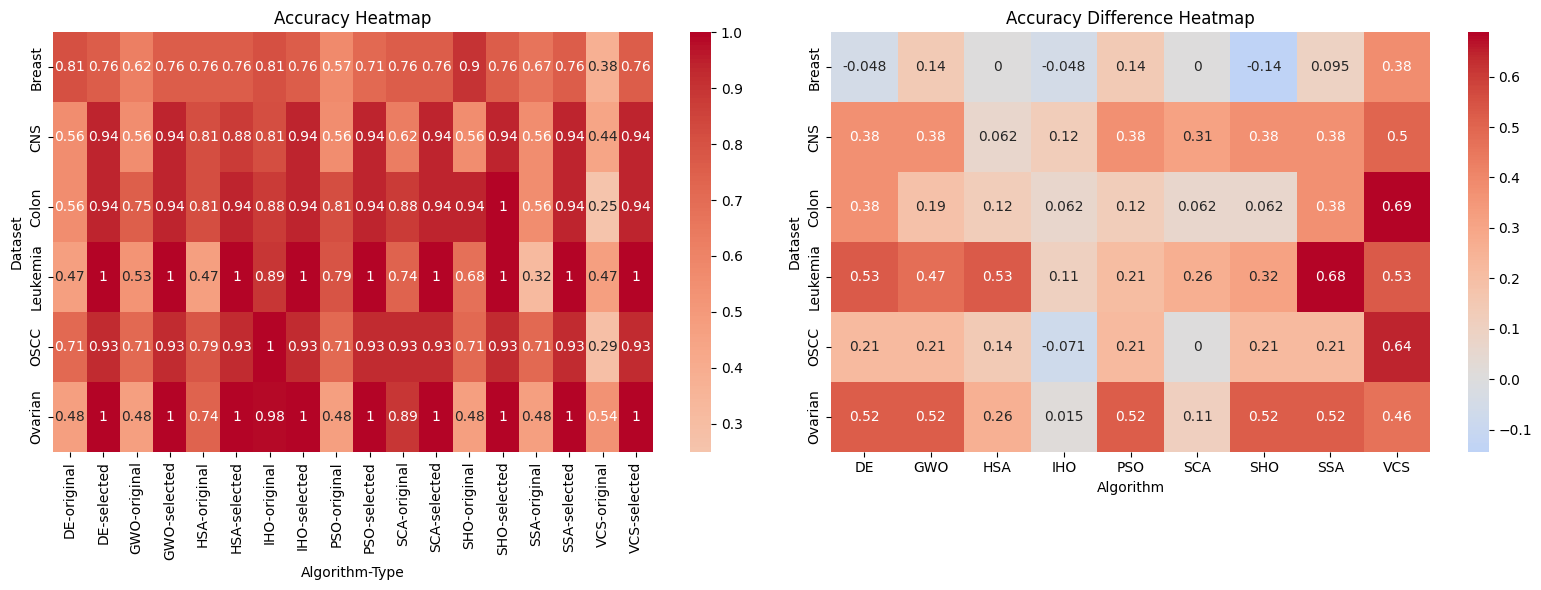

In [ ]:
accuracy_ori = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/accuracy_FS.csv')
accuracy_sel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/accuracy_selected_FS.csv')
num_sel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/num_features_FS.csv')

# Assuming accuracy_ori, accuracy_sel have accuracy data in columns named 'DE', 'IHO', etc.
# Get a list of algorithm names (columns other than 'Dataset')
algorithm_names = [col for col in accuracy_ori.columns if col != 'Dataset']

# Melt the DataFrames to long format
accuracy_ori_long = pd.melt(accuracy_ori, id_vars=['Dataset'], value_vars=algorithm_names, var_name='Algorithm', value_name='Accuracy')
accuracy_sel_long = pd.melt(accuracy_sel, id_vars=['Dataset'], value_vars=algorithm_names, var_name='Algorithm', value_name='Accuracy')

# Add a column to distinguish between original and selected accuracies
accuracy_ori_long['Type'] = 'original'
accuracy_sel_long['Type'] = 'selected'

# Concatenate the long DataFrames
all_accuracy = pd.concat([accuracy_ori_long, accuracy_sel_long], ignore_index=True)

# Calculate Accuracy Difference using groupby and diff
all_accuracy['Accuracy Difference'] = all_accuracy.groupby(['Dataset', 'Algorithm'])['Accuracy'].diff().fillna(0)

# Pivot the DataFrame to create the heatmap for Accuracy
pivot_df_accuracy = all_accuracy.pivot_table(
    index='Dataset',
    columns=['Algorithm', 'Type'],
    values='Accuracy'
)

# Pivot the DataFrame to create the heatmap for Accuracy Difference
# Since Accuracy Difference is calculated per (Dataset, Algorithm), we need a separate pivot
pivot_df_diff = all_accuracy.pivot_table(
    index='Dataset',
    columns=['Algorithm'],  # No need for 'Type' here as difference is between 'original' and 'selected'
    values='Accuracy Difference',
    aggfunc='sum'  # Sum the differences if there are multiple
).fillna(0)  # Fill any NaN with 0 if needed


plt.figure(figsize=(16, 6))  # Adjusted figure size to accommodate both heatmaps

# Heatmap for Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.heatmap(pivot_df_accuracy, annot=True, cmap='coolwarm', center=0)
plt.title('Accuracy Heatmap')

# Heatmap for Accuracy Difference
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.heatmap(pivot_df_diff, annot=True, cmap='coolwarm', center=0)
plt.title('Accuracy Difference Heatmap')

plt.tight_layout()
plt.show()

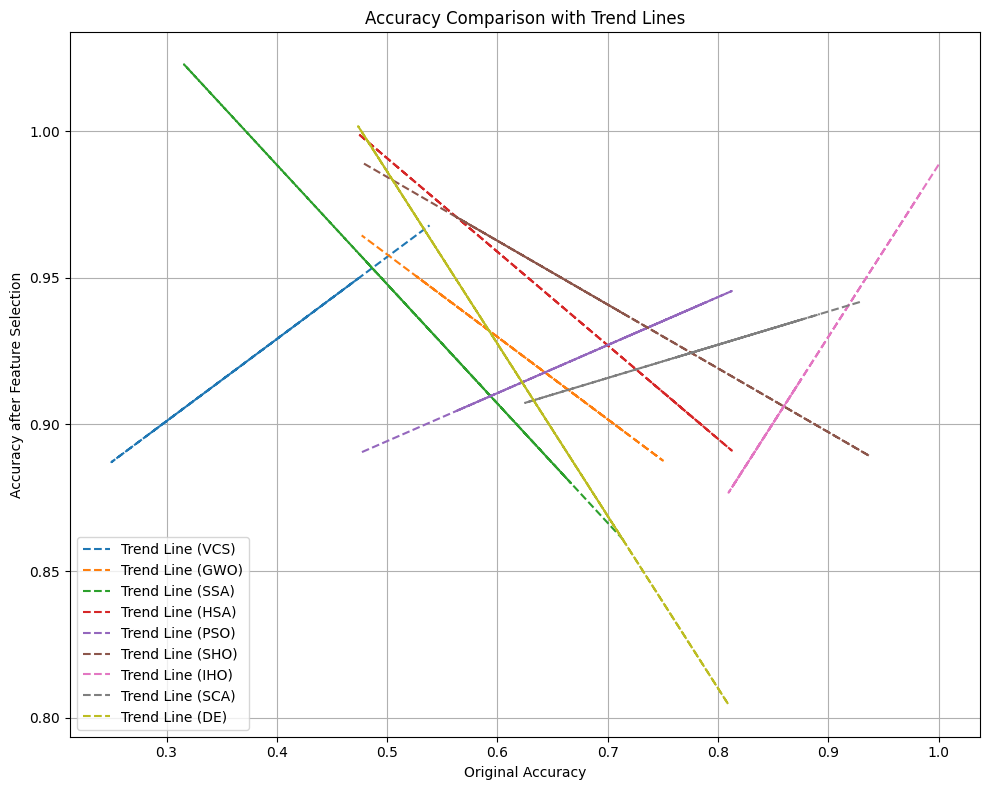

In [ ]:
accuracy_ori = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/accuracy_FS.csv')
accuracy_sel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/accuracy_selected_FS.csv')
num_sel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Microarray Datasets Hybrid optimization Algorithm/Results/Feature_selection/num_features_FS.csv')

plt.figure(figsize=(10, 8))
# ... (your existing code to plot scatter points) ...

# Get the actual algorithm names from the columns (excluding 'Dataset')
algorithm_names = accuracy_ori.columns[1:]

# Loop through each algorithm to add trend lines
for algorithm in algorithm_names:
    coefficients = np.polyfit(accuracy_ori[algorithm], accuracy_sel[algorithm], 1)
    polynomial = np.poly1d(coefficients)
    plt.plot(accuracy_ori[algorithm], polynomial(accuracy_ori[algorithm]),
             linestyle='--', label=f'Trend Line ({algorithm})')

plt.xlabel("Original Accuracy")
plt.ylabel("Accuracy after Feature Selection")
plt.title("Accuracy Comparison with Trend Lines")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC-AUC and Precision-Recall Curve

Processing dataset: oscc
Processing algorithm: DE


DE Optimization: 100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


Processing algorithm: IHO


IHO Optimization: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Processing algorithm: GWO


GWO Optimization: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Processing algorithm: HSA


HSA Optimization: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Processing algorithm: PSO


PSO Optimization: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Processing algorithm: SCA


SCA Optimization: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Processing algorithm: SSA


SSA Optimization: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


Processing algorithm: VCS


VCS Optimization: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Processing algorithm: SHO


SHO Optimization: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Processing dataset: cns
Processing algorithm: DE


DE Optimization: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Processing algorithm: IHO


IHO Optimization: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Processing algorithm: GWO


GWO Optimization: 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


Processing algorithm: HSA


HSA Optimization: 100%|██████████| 10/10 [00:01<00:00,  7.10it/s]


Processing algorithm: PSO


PSO Optimization: 100%|██████████| 10/10 [00:00<00:00, 12.40it/s]


Processing algorithm: SCA


SCA Optimization: 100%|██████████| 10/10 [00:00<00:00, 13.59it/s]


Processing algorithm: SSA


SSA Optimization: 100%|██████████| 10/10 [00:00<00:00, 12.78it/s]


Processing algorithm: VCS


VCS Optimization: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Processing algorithm: SHO


SHO Optimization: 100%|██████████| 10/10 [00:00<00:00, 10.63it/s]


Processing dataset: breast
Processing algorithm: DE


DE Optimization: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


Processing algorithm: IHO


IHO Optimization: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Processing algorithm: GWO


GWO Optimization: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Processing algorithm: HSA


HSA Optimization: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Processing algorithm: PSO


PSO Optimization: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


Processing algorithm: SCA


SCA Optimization: 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Processing algorithm: SSA


SSA Optimization: 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


Processing algorithm: VCS


VCS Optimization: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Processing algorithm: SHO


SHO Optimization: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Processing dataset: colon
Processing algorithm: DE


DE Optimization: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]


Processing algorithm: IHO


IHO Optimization: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s]


Processing algorithm: GWO


GWO Optimization: 100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


Processing algorithm: HSA


HSA Optimization: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


Processing algorithm: PSO


PSO Optimization: 100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Processing algorithm: SCA


SCA Optimization: 100%|██████████| 10/10 [00:00<00:00, 11.35it/s]


Processing algorithm: SSA


SSA Optimization: 100%|██████████| 10/10 [00:00<00:00, 18.55it/s]


Processing algorithm: VCS


VCS Optimization: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


Processing algorithm: SHO


SHO Optimization: 100%|██████████| 10/10 [00:00<00:00, 17.34it/s]


Processing dataset: ovarian
Processing algorithm: DE


DE Optimization: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Processing algorithm: IHO


IHO Optimization: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Processing algorithm: GWO


GWO Optimization: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Processing algorithm: HSA


HSA Optimization: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Processing algorithm: PSO


PSO Optimization: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Processing algorithm: SCA


SCA Optimization: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Processing algorithm: SSA


SSA Optimization: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Processing algorithm: VCS


VCS Optimization: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Processing algorithm: SHO


SHO Optimization: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Processing dataset: leukemia
Processing algorithm: DE


DE Optimization: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Processing algorithm: IHO


IHO Optimization: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Processing algorithm: GWO


GWO Optimization: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Processing algorithm: HSA


HSA Optimization: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Processing algorithm: PSO


PSO Optimization: 100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Processing algorithm: SCA


SCA Optimization: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


Processing algorithm: SSA


SSA Optimization: 100%|██████████| 10/10 [00:01<00:00,  9.50it/s]


Processing algorithm: VCS


VCS Optimization: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Processing algorithm: SHO


SHO Optimization: 100%|██████████| 10/10 [00:00<00:00, 10.86it/s]


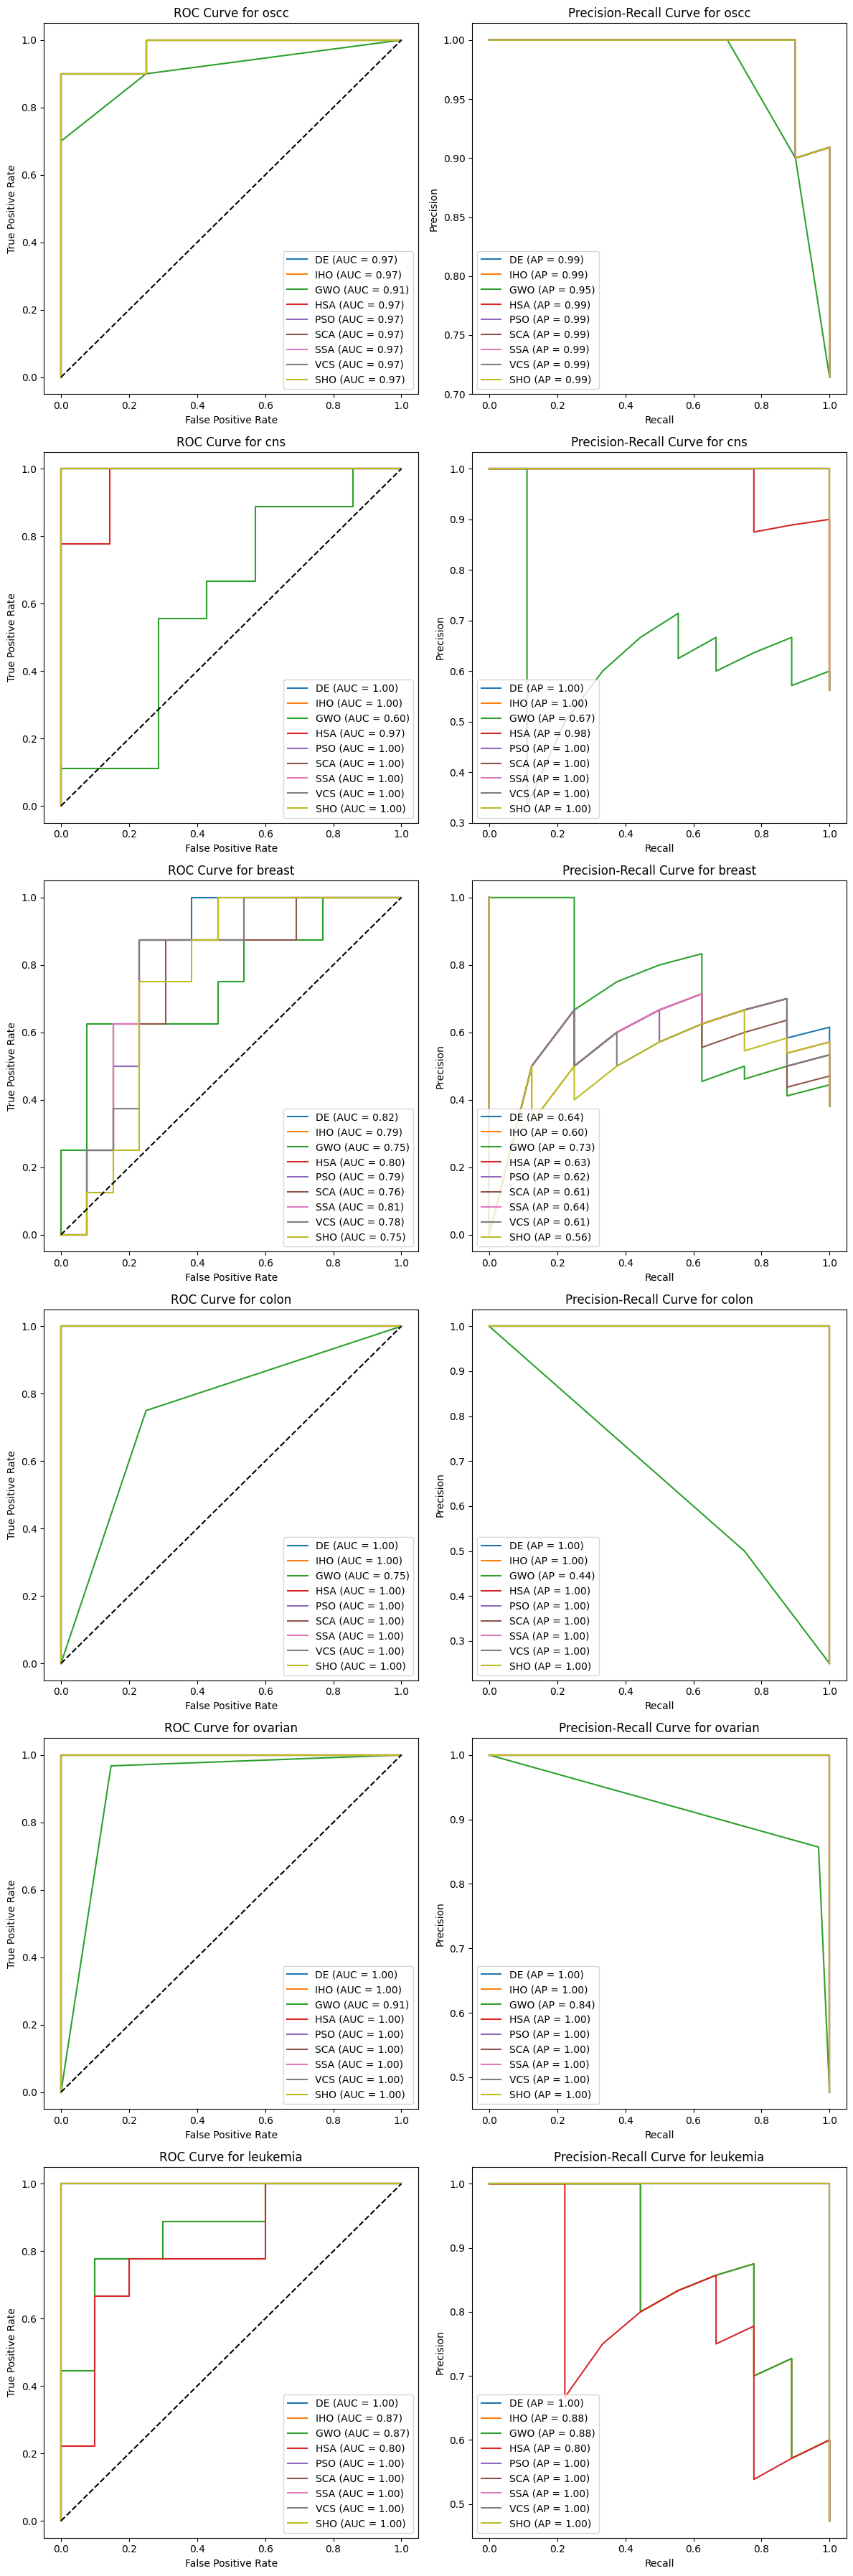

In [ ]:
datasets = {
    'oscc': oscc,
    'cns': cns,
    'breast': breast,
    'colon': colon,
    'ovarian': ovarian,
    'leukemia': leukemia
}

algorithms = ['DE', 'IHO', 'GWO', 'HSA', 'PSO', 'SCA', 'SSA', 'VCS', 'SHO']

def plot_roc_pr_curves_grid(datasets, algorithms):
    """
    Creates a 6x2 subplot grid to display ROC and PR curves for all datasets.

    Args:
        datasets (dict): Dictionary of datasets (name: DataFrame).
        algorithms (list): List of algorithm names.
    """

    num_datasets = len(datasets)
    fig, axes = plt.subplots(num_datasets, 2, figsize=(12, num_datasets * 6))  # Adjust figsize as needed

    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        print(f"Processing dataset: {dataset_name}")

        X = dataset.drop('Target', axis=1).values
        y = dataset['Target'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        y_scores_per_algo = {}  # Store y_scores for each algorithm
        max_iterations = 10  # Adjust as needed

        for algo in algorithms:
            print(f"Processing algorithm: {algo}")
            if algo == 'DE':
                best, best_fitness, fitness_history, best_intercept, f_name = DE(
                    X, y, pop_size=50, max_iters=max_iterations, scaling_factor=0.5, crossover_probability=0.5, alpha=0.0)
            if algo == 'IHO':
                best, best_fitness, fitness_history, best_intercept, f_name = IHO(
                    X, y, pop_size=50, max_iter=max_iterations, infection_rate=0.2, mutation_rate=0.3, a_max=2, alpha=0.0)
            if algo == 'GWO':
                best, best_fitness, fitness_history, best_intercept, f_name = GWO(
                    X, y, pop_size=50, max_iters=max_iterations, alpha=0.0)
            if algo == 'HSA':
                best, best_fitness, fitness_history, best_intercept, f_name = HSA(
                    X, y, pop_size=50, max_iters=max_iterations, l=0.08, LH=100, alpha=0.0)
            if algo == 'PSO':
                best, best_fitness, fitness_history, best_intercept, f_name = PSO(
                    X, y, pop_size=50, max_iters=max_iterations, c1=2, c2=2, v_max=6, w=1, alpha=0.0)
            if algo == 'SCA':
                best, best_fitness, fitness_history, best_intercept, f_name = SCA(
                    X, y, pop_size=50, max_iters=max_iterations, A=2, alpha=0.0)
            if algo == 'SSA':
                best, best_fitness, fitness_history, best_intercept, f_name = SSA(
                    X, y, pop_size=50, max_iters=max_iterations, c1_range=(0, 1), c2_range=(0, 1), alpha=0.0)
            if algo == 'VCS':
                best, best_fitness, fitness_history, best_intercept, f_name = VCS(
                    X, y, pop_size=50, max_iters=max_iterations, infection_rate=0.1, mutation_rate=0.2, alpha=0.0)
            if algo == 'SHO':
                best, best_fitness, fitness_history, best_intercept, f_name = SHO(
                    X, y, pop_size=50, max_iter=max_iterations, a=2, alpha=0.0)

            # Apply feature selection using the 'best' coefficients from IHO
            # Apply the best coefficients to the features
            X_train_selected = X_train * best  # Or use important_feature_indices if you have them
            X_test_selected = X_test * best

            # threshold = 0.0  # Adjust the threshold as needed
            # important_feature_indices = np.where(np.abs(best) > threshold)[0]

            # X_train_selected = X_train[:, important_feature_indices]
            # X_test_selected = X_test[:, important_feature_indices]

            # Initialize and train a logistic regression classifier
            classifier = LogisticRegression()
            classifier.fit(X_train_selected, y_train)

            # Predict probabilities for ROC-AUC and Precision-Recall
            y_scores = classifier.predict_proba(X_test_selected)[:, 1]
            y_scores_per_algo[algo] = y_scores

        # Plot ROC curve on the first column of the current row
        ax1 = axes[i, 0]  # Get the subplot for ROC curve
        for algo, y_scores in y_scores_per_algo.items():
            fpr, tpr, _ = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)
            ax1.plot(fpr, tpr, label=f'{algo} (AUC = {roc_auc:.2f})')
        ax1.plot([0, 1], [0, 1], 'k--')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title(f'ROC Curve for {dataset_name}')
        ax1.legend(loc="lower right")

        # Plot Precision-Recall curve on the second column of the current row
        ax2 = axes[i, 1]  # Get the subplot for PR curve
        for algo, y_scores in y_scores_per_algo.items():
            precision, recall, _ = precision_recall_curve(y_test, y_scores)
            avg_precision = average_precision_score(y_test, y_scores)
            ax2.plot(recall, precision, label=f'{algo} (AP = {avg_precision:.2f})')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title(f'Precision-Recall Curve for {dataset_name}')
        ax2.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Call the function to plot the curves
plot_roc_pr_curves_grid(datasets, algorithms)